In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')

import distances_helper as dh 
import print_helper as ph
import create_model_helper as cmh
import build_convex_hull_helper as bchh
import test_vs_original_columns_helper as tvsoch
import compare_two_models as ctm

from plot_helper import PlotMaker
from config_helper import ConfigPaths
from scipy.optimize import minimize

pd.options.display.max_rows = 999

0.8.1


In [3]:
config = ConfigPaths('config_sample_m2.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()

batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model2\np_28_03_2_no_reg\models.txt


In [4]:
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def plot_convex_hull_topics_iterations_distribution(_phi_convex_hull):
    get_iteration_number_fn = lambda x: int(x[x.find('_', 6) + 1 : ])
    phi_convex_hull_iteration_number = [get_iteration_number_fn(col) for col in _phi_convex_hull.columns]
    phi_convex_hull_iteration_number = [(val, phi_convex_hull_iteration_number.count(val), 1.0 * phi_convex_hull_iteration_number.count(val) / len(phi_convex_hull_iteration_number)) for val in set(phi_convex_hull_iteration_number)]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[1] for x in phi_convex_hull_iteration_number], ax=ax1)
    ax1.set_title('Number of topics from each iteration')
    ax1.set_xlabel('n iteration')

    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[2] for x in phi_convex_hull_iteration_number], ax=ax2)
    ax2.set_title('Number of topics from each iteration (%)')
    ax2.set_xlabel('n iteration')
def plot_convex_hull_columns_change(iterations_info):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    ax1.plot([sum([val['n_topics_to_remove']for val in it['iterations_info_filter']]) for it in iterations_info], 
             color='r', label = 'total')
    ax1.set_title('Num columns to remove')
    get_topic_iteration_fn = lambda x: int(x[x.rfind('_') + 1 :])
    get_topic_filter_iteration_list_fn = lambda x, y: [get_topic_iteration_fn(topic) for topic in x].count(y)
    n_topics_removed_from_current_iteration = [sum([get_topic_filter_iteration_list_fn(val['removed_topics'], indx) for val in it['iterations_info_filter']]) for indx, it in enumerate(iterations_info)]
    ax1.plot(n_topics_removed_from_current_iteration, color='b', label='current iteration')
    ax1.set_xlabel('n iteration')
    ax1.legend()

    ax2.plot([val['phi_convex_hull_shape'][1] for val in iterations_info], color='r')
    ax2.set_title('Num columns of convex hull')
    ax2.set_xlabel('n iteration')
    ax2.legend()
def plot_opt_res_fun(iterations_filtering_info_name):
    %matplotlib inline
    iterations_filtering_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_filtering_info for val in item for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item for x in val['opt_res'].values()] for item in iterations_filtering_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def plot_opt_res_fun_filtering(iterations_filtering_info_name):
    iterations_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_info for val in item['iterations_info_filter'] for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item['iterations_info_filter'] for x in val['opt_res'].values()] for item in iterations_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def get_phi_granularity(phi):
    return np.mean([get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()])
def get_words_close_to_th_count(col, global_th=0.95):
    cur_sum, sum_count = 0, 0
    for val in col.sort_values()[::-1]:
        if cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_opt_x_granularity(opt):
    return np.mean([get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt.iteritems()])
def get_opt_x_close_to_th_count(opt_x, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    opt_x_val = opt_x.copy()
    if cut_th != None:
        opt_x_val[opt_x_val < cut_th] = 0
    for val in sorted(opt_x_val)[::-1]:
        if val !=0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_and_plot_granularity(phi, opt_to_original, name):
    x_count_grans = [get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean = np.mean(x_count_grans)
    x_count_grans_th = [get_opt_x_close_to_th_count(opt_res.x, cut_th=5*1e-2)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean_th = np.mean(x_count_grans_th)
    grans = [get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()]
    grans_mean = np.mean(grans) 
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    sns.distplot(x_count_grans, color='r', bins=5, ax=ax1)
    sns.distplot(x_count_grans_th, color='b', bins=5, ax=ax1)
    for topic, opt_res in opt_to_original.iteritems():
        ax2.plot(sorted(opt_res.x)[::-1])
    sns.distplot(grans, color='r', bins=5, ax=ax3)
    title = '{} {} \nx_count_grans_mean = {}; th={}'.format(name, phi.shape, x_count_grans_mean, x_count_grans_mean_th)
    ax1.set_title(title)
    title = '{} {} \ngrans_mean = {}'.format(name, phi.shape, grans_mean)
    ax3.set_title(title)

    return x_count_grans, x_count_grans_mean, grans, grans_mean

def plot_different_distances(different_distances, title):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    
    if dh.kl_dist in different_distances.keys():
        vals = different_distances[dh.kl_dist].values.flatten()
        sns.distplot(vals, color='y', ax=ax1, label='kl')
    if dh.kl_sym_dist in different_distances.keys():
        vals = different_distances[dh.kl_sym_dist].values.flatten()
        sns.distplot(vals, color='m', ax=ax1, label='kl_sym')
    
    vals = different_distances[dh.jaccard_dist].values.flatten()
    sns.distplot(vals, color='r', ax=ax2, label='jaccard')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='r', ax=ax3, label='jaccard')

    vals = different_distances[dh.cos_dist].values.flatten()
    sns.distplot(vals,  color='b', ax=ax2, label='cos')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='b', ax=ax3, label='cos')

    vals = different_distances[dh.hellinger_dist].values.flatten()
    sns.distplot(vals, color='g', ax=ax2, label='hellinger')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='g', ax=ax3, label='hellinger')
    ax1.legend()
    ax2.legend()    
    if title != '':
        fig.suptitle(title, fontsize=14, fontweight='bold')
    
def get_distances(phi):
    different_distances = {}
    distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]
    for dist_fn in distances:
        different_distances[dist_fn] = dh.calculate_distances(dist_fn, phi, phi)
    return different_distances
def save_and_plot(idx, names_list, phi_convex_hull_list, iterations_info_list, iterations_filtering_list):
    save_pickle_file(phi_convex_hull_list[idx], 'phi_convex_hull___' + names_list[idx])
    save_pickle_file(iterations_info_list[idx], 'iterations_info_list___' + names_list[idx])
    save_pickle_file(iterations_filtering_list[idx], 'iterations_filtering_list___' + names_list[idx])

    plot_convex_hull_topics_iterations_distribution(phi_convex_hull_list[idx])
    plot_convex_hull_columns_change(iterations_info_list[idx])

    distances_to_original_list = bchh.calculate_distances(DIST_FN, phi_convex_hull_list[idx], phi_original)
    opt_res_to_original_list = bchh.get_optimization_result(DIST_FN, None, phi_convex_hull_list[idx], phi_original,
                                                       distances_to_original_list[idx], n_closest_topics=N_CLOSEST_TOPICS_COUNT)
    opt_original_to_res_list = bchh.get_optimization_result(DIST_FN, None, phi_original,  phi_convex_hull_list[idx],
                                                       distances_to_original_list[idx].T, n_closest_topics=N_CLOSEST_TOPICS_COUNT)

    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_res_to_original_list[idx], names_list[idx])
    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_original_to_res_list[idx], names_list[idx])
    plot_dists(opt_res_to_original_list[idx], opt_original_to_res_list[idx], names_list[idx])
    
    different_distances = get_distances(phi_convex_hull_list[idx])
    different_distances_to_original = tvsoch.get_test_to_original_result_different_distances(phi_convex_hull_list[idx], phi_convex_hull_list[idx])
    tvsoch.plot_original_columns_count_different_distances(different_distances_to_original, n_original_columns_count=100)
    plot_different_distances(different_distances)
    return distances_to_original_list, opt_res_to_original_list, opt_original_to_res_list, different_distances, different_distances_to_original


Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [5]:
phi_original, theta_original = load_pickle_file('phi_model2.p', config.output_batches_path), load_pickle_file('theta_model2.p', config.output_batches_path)
phi_nwt_original = pd.DataFrame(0, index=phi_original.index, columns=[])
print phi_original.shape, theta_original.shape

(8051, 100) (100, 3446)


In [10]:
def check_topic_ok(topic_phi, _debug=False):
    if type(topic_phi) != np.ndarray:
        topic_phi = np.array(topic_phi)
    significant_element_th_large, significant_element_th_small = 0.01, 0.005
    significant_elements_count_large, significant_elements_count_small = 5, 10
    # sum must be != 0 (after regulizators some topics may be zero)
    topic_sum_rule = np.sum(topic_phi) > 1e-1
    # topic must have at least n words with probability greater that th
    topic_significant_elements_count_large = len(np.where(topic_phi > significant_element_th_large)[0])
    topic_significant_elements_count_small = len(np.where(topic_phi > significant_element_th_small)[0])
    topic_significant_elements_large_rule = topic_significant_elements_count_large >= significant_elements_count_large
    topic_significant_elements_small_rule = topic_significant_elements_count_small >= significant_elements_count_small
    topic_docs_count_rule = None
    if _debug:
        print('topic_sum_rule = {} [{}], topic_significant_elements_large_rule = {} [{}], topic_significant_elements_small_rule = {} [{}]' \
              .format(topic_sum_rule, np.sum(topic_phi), 
                      topic_significant_elements_large_rule, topic_significant_elements_count_large, 
                      topic_significant_elements_small_rule, topic_significant_elements_count_small))
    return topic_sum_rule and topic_significant_elements_large_rule and topic_significant_elements_small_rule

def get_distances(phi, distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]):
    different_distances = {}    
    for dist_fn in distances:
        print('Processing {}'.format(dist_fn))
        tmp = dh.calculate_distances(dist_fn, phi, phi)        
        if not np.any(tmp == np.inf) and not np.any(tmp == np.nan):
            different_distances[dist_fn] = tmp
    return different_distances
def reg_experiment(phi_original, phi_test, phi_nwt_original, phi_nwt_test):
    different_inter_distances_closest_1, different_inter_distances_closest_2 = None, None
    different_inter_distances_1, different_inter_distances_2 = None, None
    different_to_original_distances_closest_1, different_to_test_distances_closest_2 = None, None
    different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = None, None, None
    try:
        ph.print_phi_top_tokens(phi_original, phi_test, n_top_tokens=13)
            
        models_compare_matrix = ctm.print_models_comparasion(phi_original, phi_test, phi_nwt_original, phi_nwt_test)

        % matplotlib inline
        different_inter_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1], 
                                                               title='closest by dist inter 1')
        different_inter_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist inter 2')


        different_inter_distances_1 = get_distances(phi_original)
        plot_different_distances(different_inter_distances_1, 'inter distances 1')
        different_inter_distances_2 = get_distances(phi_test)
        plot_different_distances(different_inter_distances_2, 'inter distances 2')


        different_to_original_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_to_original_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by dist test/original')
        different_to_test_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_to_test_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist original/test')


        different_to_original_opts_1 = tvsoch.get_test_to_original_opt_result_different_distances(phi_test, phi_original,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_original_opts_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by opt test/original')
        different_to_test_opts_2 = tvsoch.get_test_to_original_opt_result_different_distances(phi_original, phi_test,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_test_opts_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by opt original/test')


        print different_to_original_opts_1[dh.hellinger_dist][1][1]
        
    except Exception as inst:
        print('An error happened')
        print type(inst)     # the exception instance
        print inst.args      # arguments stored in .args
        print inst           
        ;
    return different_inter_distances_closest_1, different_inter_distances_closest_2, \
           different_inter_distances_1, different_inter_distances_2, \
           different_to_original_distances_closest_1, different_to_test_distances_closest_2, \
           different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix
def print_phi_top_tokens(phi, topic_name, n_top_tokens=13):
    topic = phi.loc[:, topic_name]
    top_tokens_and_weight = ' '.join([u'{0}: {1:.3f}'.format(topic, weight) for topic, weight in topic.sort_values()[::-1][0:n_top_tokens].iteritems() if weight != 0])
    print(topic_name + '| ' + top_tokens_and_weight)
    
def experiment_result_to_df(different_to_original_distances_closest_1, different_to_test_distances_closest_2, \
                            different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix, init_num_topics,
                            first_index):
    def get_result_by_distance_and_th(different_fns_ths, dist_fn, th):
        if th not in different_fns_ths[dist_fn][1].keys():
            tmp = [(key, abs(key - th)) for key in different_fns_ths[dist_fn][1].keys()]
            tmp = sorted(tmp, key=lambda x: x[1])
            th = tmp[0][0]
        return different_fns_ths[dist_fn][1][th]
    def res_to_str(different_fns_ths, th):
        j_res = len(get_result_by_distance_and_th(different_fns_ths, dh.jaccard_dist, th))
        h_res = len(get_result_by_distance_and_th(different_fns_ths, dh.hellinger_dist, th))
        if j_res == h_res:
            res = 'jh{}'.format(j_res)
        else:
            res = 'j{}-h{}'.format(j_res, h_res)
        return res
    def get_second_index(init_num_topics, models_compare_matrix):
        num_topics = models_compare_matrix.loc['num topics', 'phi_2']
        zero_ratio = models_compare_matrix.loc['non zero ratio', 'phi_2']
        return '{0} -> {1:0.0f}, {2:0.2f}'.format(init_num_topics, num_topics, zero_ratio)
    def get_second_line(models_compare_matrix):
        def get_quantile_res(models_compare_matrix, index_name):
            tmp1 = models_compare_matrix.loc[index_name, 'phi_1']
            tmp2 = models_compare_matrix.loc[index_name, 'phi_2']
            is_diff = abs(tmp1 - tmp2) / tmp1 < 0.3
            res = '+' if is_diff else '-'
            return res
        avg_size = models_compare_matrix.loc['topic_kernel_average_size', 'phi_2']
        avg_purity = models_compare_matrix.loc['topic_kernel_average_purity', 'phi_2']
        avg_contrast = models_compare_matrix.loc['topic_kernel_average_contrast', 'phi_2']
        indices_names = ['|phi_ij > 0.2| / n_topics', '|phi_ij > 0.1| / n_topics', '|phi_ij > 0.01| / n_topics',
                         '|phi_ij > 0.05| / n_topics', '|phi_ij > 0.001| / n_topics']
        compare_quantile = ''.join([get_quantile_res(models_compare_matrix, index_name) for index_name in indices_names])
        res = ['24 vs {0:0.0f}'.format(avg_size), '.63 vs {0:.2f}'.format(avg_purity), '.78 vs {0:.2f}'.format(avg_contrast), compare_quantile]
        return res
    
    df = pd.DataFrame(0, columns=[0.2, 0.4, 0.6, 0.8], index = [])
    df.loc[first_index] = ['-', '-', '-', '-']
    second_index = get_second_index(init_num_topics, models_compare_matrix)
    second_line = get_second_line(models_compare_matrix)
    df.loc[second_index] = second_line 
    for th in [0.2, 0.4, 0.6, 0.8]:
        df.loc['closest by dist test/original', th] = res_to_str(different_to_original_distances_closest_1, th)
        df.loc['closest by dist original/test', th] = res_to_str(different_to_test_distances_closest_2, th)
        df.loc['closest by opt res test/original', th] = res_to_str(different_to_original_opts_1, th)
        df.loc['closest by opt res original/test', th] = res_to_str(different_to_test_opts_2, th)
    return df

# Choose models
Построить несколько моделей с отбором тем. Выводить число оставшихся необнулившихся колонок фи/тета.

In [7]:
models_count = 100
names_list, models_list = [0] * models_count, [0] * models_count
phi_list, phi_nwt_list, theta_list = [0] * models_count, [0] * models_count, [0] * models_count
phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list = [0] * models_count, [0] * models_count, [0] * models_count
result_dfs = [0] * models_count

different_inter_distances_closest_1, different_inter_distances_closest_2 = [0] * models_count, [0] * models_count
different_inter_distances_1, different_inter_distances_2 = [0] * models_count, [0] * models_count
different_to_original_distances_closest_1, different_to_test_distances_closest_2 = [0] * models_count, [0] * models_count
different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = [0] * models_count, [0] * models_count, [0] * models_count

In [8]:
[different_inter_distances_closest_1, different_inter_distances_closest_2, 
        different_inter_distances_1, different_inter_distances_2, 
        different_to_original_distances_closest_1, different_to_test_distances_closest_2, 
        different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix] = load_pickle_file('result_no_reg.p')
[names_list, phi_list, phi_nwt_list, theta_list,
                  phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list] = load_pickle_file('init_no_reg.p')

# different topics number

name = create_model_dtn_20_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | работа: 0.042 трудность: 0.029 программа: 0.020 опрос: 0.017 рабочий: 0.014 вид: 0.012 условие: 0.011 работник: 0.011 возможность: 0.010 миллион: 0.010 цель: 0.010 британия: 0.009 результат: 0.008
topic_1 | словарь: 0.062 слово: 0.039 глагол: 0.039 предложение: 0.038 значение: 0.032 форма: 0.026 орех: 0.023 существительное: 0.018 падеж: 0.015 единица: 0.015 пример: 0.014 тип: 0.013 грамматика: 0.012
topic_2 | клетка: 0.151 бел

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.91
|phi_ij == 0| / n_topics       7689.02  7297.25
|phi_ij > 0.2| / n_topics         0.03     0.10
|phi_ij > 0.1| / n_topics         0.31     0.60
|phi_ij > 0.01| / n_topics       14.64    20.80
|phi_ij > 0.05| / n_topics        1.21     2.00
|phi_ij > 0.001| / n_topics     214.17   134.05
topic_kernel_average_size        23.68   241.50
topic_kernel_average_purity       0.63     0.68
topic_kernel_average_contrast     0.78     0.84

Dist fn = <function kl_sym_dist at 0x000000000BD26908>, Processed th = 100, original columns count = 20         Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Dist fn = <function cos_dist at 0x000000000BD26A58>, Processed th = 1.0, original columns count = 20           Column topic_4 not optimized
Dist fn = <function hellinger_dist at 0x000000000BD26AC8>, Processed th = 1.0, original columns count = 20     

C:\Users\jluka\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Dist fn = <function hellinger_dist at 0x000000000BD26AC8>, Processed th = 1.0, original columns count = 20     [(u'topic_0', u'topic_17', 0, 17, 0.41352926028586079), (u'topic_1', u'topic_16', 1, 16, 0.4764141352192488), (u'topic_2', u'topic_15', 2, 15, 0.37820285388179681), (u'topic_3', u'topic_14', 3, 14, 0.49294233352963529), (u'topic_4', u'topic_13', 4, 13, 0.35594092474565103), (u'topic_5', u'topic_12', 5, 12, 0.42348892386029285), (u'topic_6', u'topic_11', 6, 11, 0.44273368783429973), (u'topic_7', u'topic_10', 7, 10, 0.44003040383981673), (u'topic_8', u'topic_19', 8, 19, 0.34531272343929975), (u'topic_9', u'topic_18', 9, 18, 0.43331175418790729), (u'topic_10', u'topic_5', 10, 5, 0.49205665695534956), (u'topic_11', u'topic_4', 11, 4, 0.32332689402703291), (u'topic_12', u'topic_3', 12, 3, 0.40356286741942882), (u'topic_13', u'topic_2', 13, 2, 0.49594931849397095), (u'topic_14', u'topic_9', 14, 9, 0.45186155645981552), (u'topic_15', u'topic_8', 15, 8, 0.3963117132565373), (u'topic_1

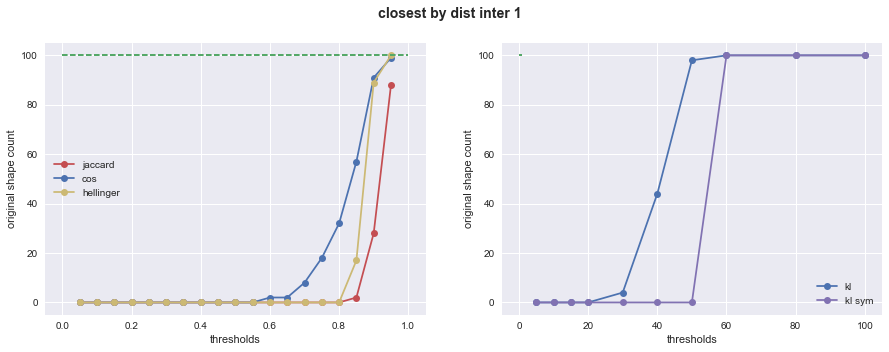

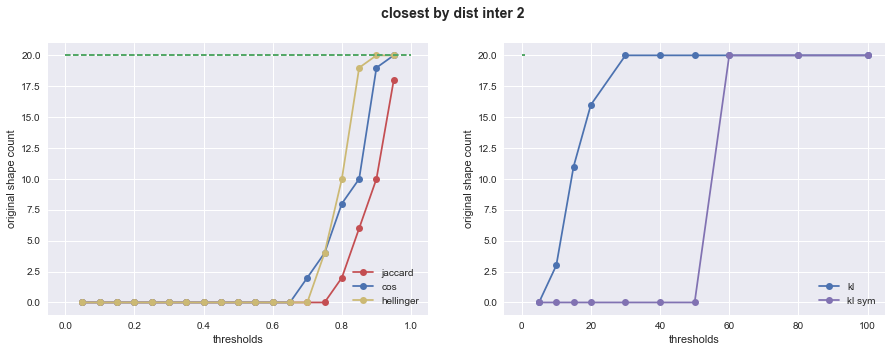

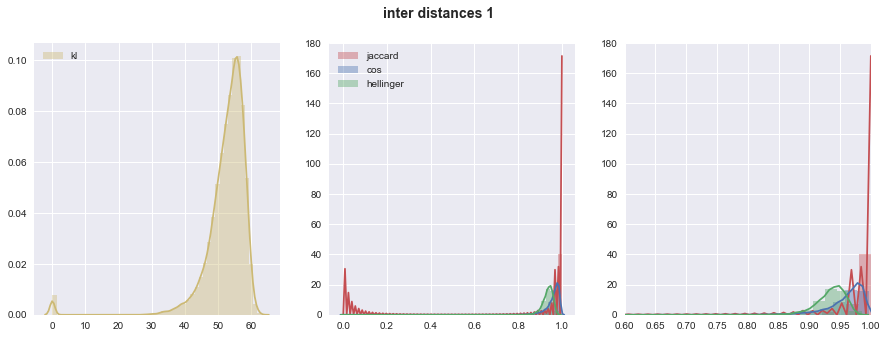

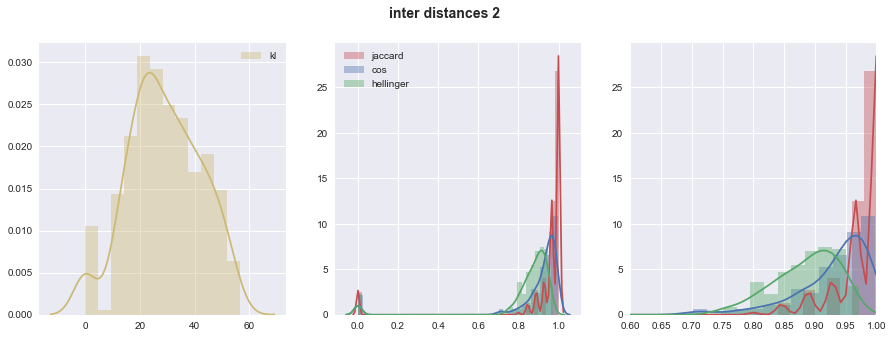

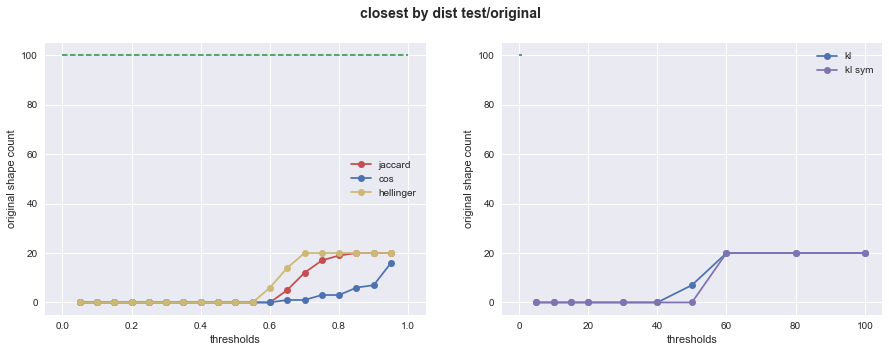

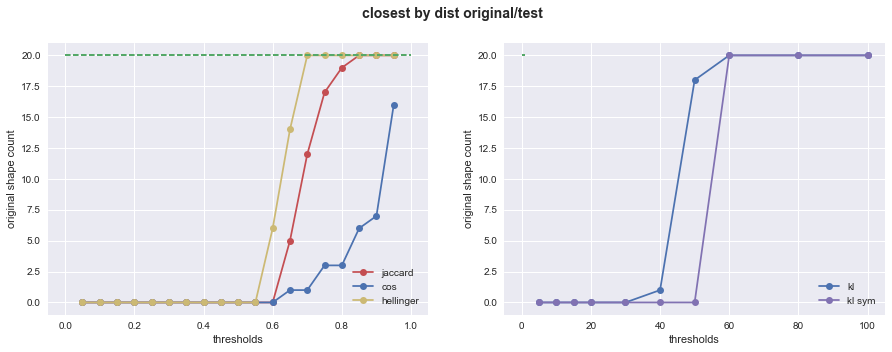

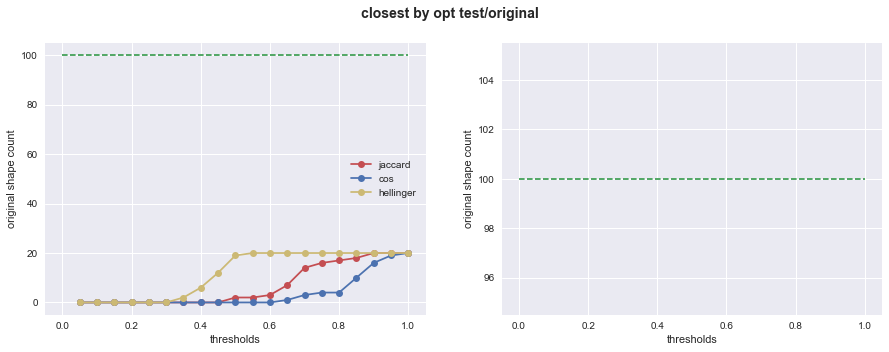

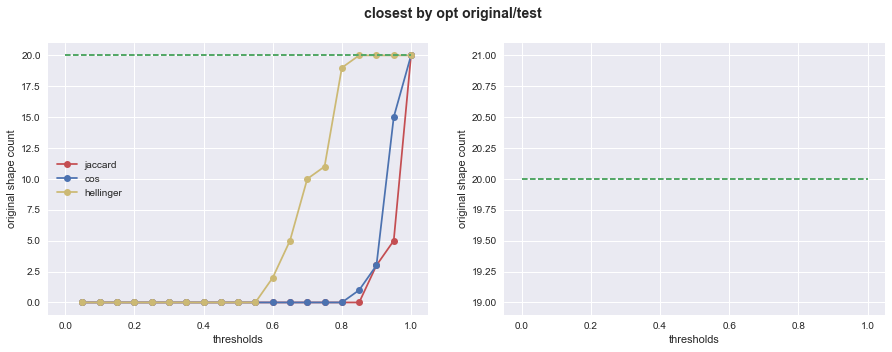

In [26]:
def create_model_dtn_20(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 21
functions_list[idx] = create_model_dtn_20
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [11]:
idx = 21
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx],
        init_num_topics=20,
        first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
create_model_dtn_20                       -            -            -        -
20 -> 20, 0.91                    24 vs 242  .63 vs 0.68  .78 vs 0.84    -----
closest by dist test/original           jh0          jh0        j0-h6  j19-h20
closest by dist original/test           jh0          jh0        j0-h6  j19-h20
closest by opt res test/original        jh0        j0-h6       j3-h20  j17-h20
closest by opt res original/test        jh0          jh0        j0-h2   j0-h19

name = create_model_dtn_50_iter_0, n_topics = 50, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 50, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | работа: 0.042 трудность: 0.029 программа

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00    50.00
non zero ratio                    0.96     0.95
|phi_ij == 0| / n_topics       7689.02  7609.58
|phi_ij > 0.2| / n_topics         0.03     0.38
|phi_ij > 0.1| / n_topics         0.31     1.18
|phi_ij > 0.01| / n_topics       14.64    20.06
|phi_ij > 0.05| / n_topics        1.21     2.80
|phi_ij > 0.001| / n_topics     214.17    97.96
topic_kernel_average_size        23.68    96.26
topic_kernel_average_purity       0.63     0.62
topic_kernel_average_contrast     0.78     0.83

Dist fn = <function kl_sym_dist at 0x000000000BD26908>, Processed th = 100, original columns count = 50         Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Dist fn = <function cos_dist at 0x000000000BD26A58>, Processed th = 1.0, original columns count = 50           Column topic_55 not optimized
Column topic_76 not optimized
Column topic_84 not optimized
Dist fn = <function hellinger_dist at 0x000000000BD26AC8>, Processed th = 1.0, original columns count = 50     [(u'topic_0', u'topic_

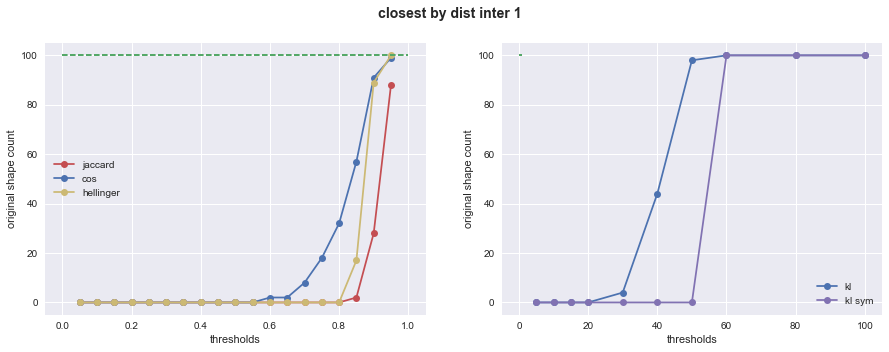

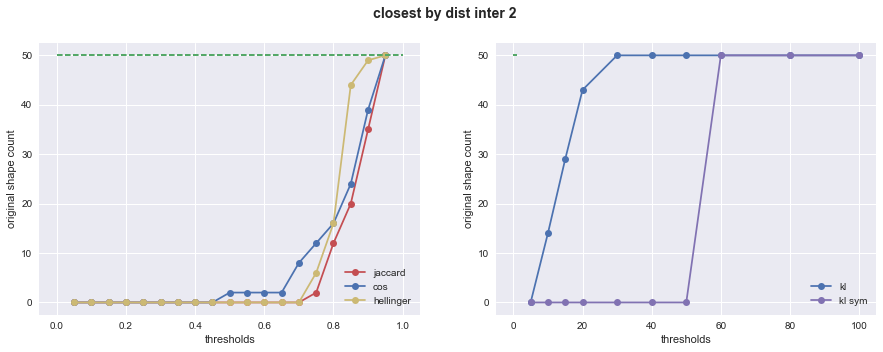

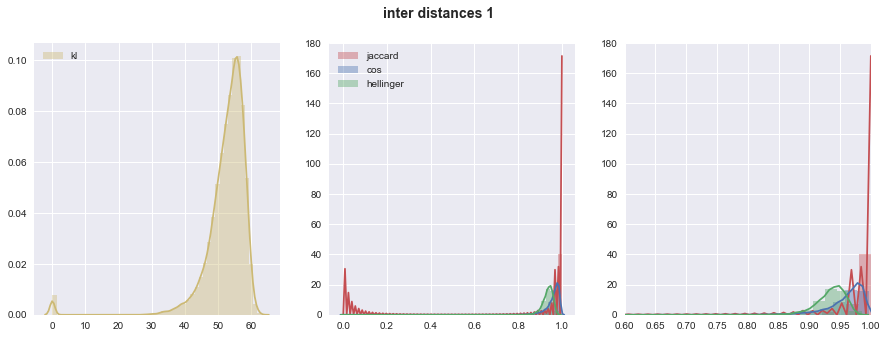

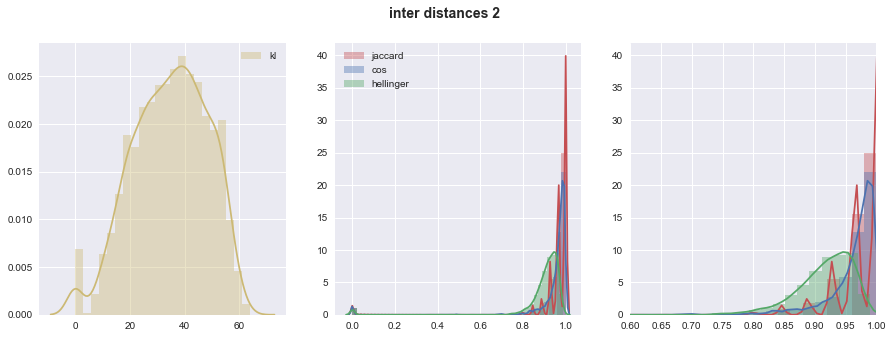

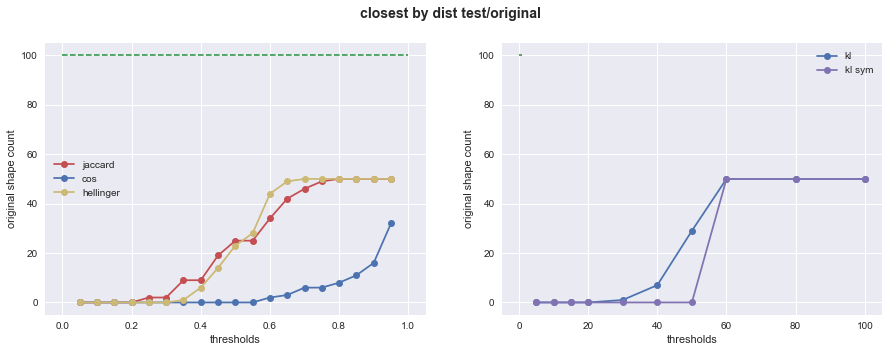

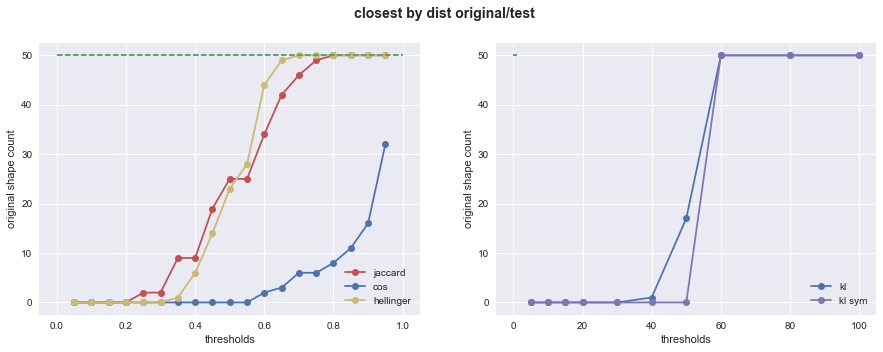

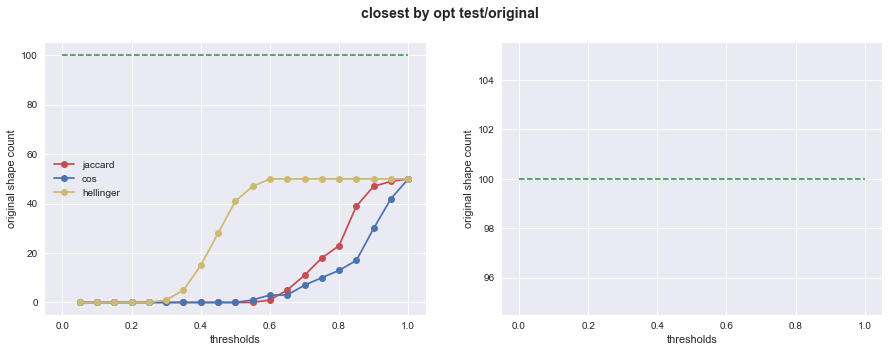

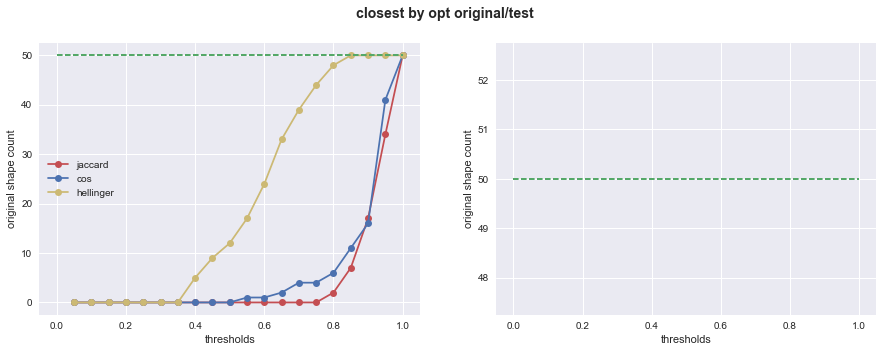

In [27]:
def create_model_dtn_50(n_iteration, model_name='', fit=True, n_topics=50):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 22
functions_list[idx] = create_model_dtn_50
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [12]:
idx = 22
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx],
        init_num_topics=50,
        first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
create_model_dtn_50                      -            -            -        -
50 -> 50, 0.95                    24 vs 96  .63 vs 0.62  .78 vs 0.83    -----
closest by dist test/original          jh0        j9-h6      j34-h44     jh50
closest by dist original/test          jh0        j9-h6      j34-h44     jh50
closest by opt res test/original       jh0       j0-h15       j1-h50  j23-h50
closest by opt res original/test       jh0        j0-h5       j0-h24   j2-h48

name = create_model_dtn_100_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 96, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topic_63', u'topic_64', u'topic_65', u'topi

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00    96.00
non zero ratio                    0.96     0.96
|phi_ij == 0| / n_topics       7689.02  7708.81
|phi_ij > 0.2| / n_topics         0.03     0.50
|phi_ij > 0.1| / n_topics         0.31     1.44
|phi_ij > 0.01| / n_topics       14.64    20.26
|phi_ij > 0.05| / n_topics        1.21     3.24
|phi_ij > 0.001| / n_topics     214.17    76.39
topic_kernel_average_size        23.68    50.03
topic_kernel_average_purity       0.63     0.59
topic_kernel_average_contrast     0.78     0.77

Dist fn = <function kl_sym_dist at 0x000000000BD26908>, Processed th = 100, original columns count = 96         Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Dist fn = <function cos_dist at 0x000000000BD26A58>, Processed th = 1.0, original columns count = 96           Column topic_1 not optimized
Column topic_5 not optimized
Column topic_17 not optimized
Column topic_28 not optimized
Column topic_32 not optimized
Column topic_37 not optimized
Column topic_40 not optimized
Column topic_44

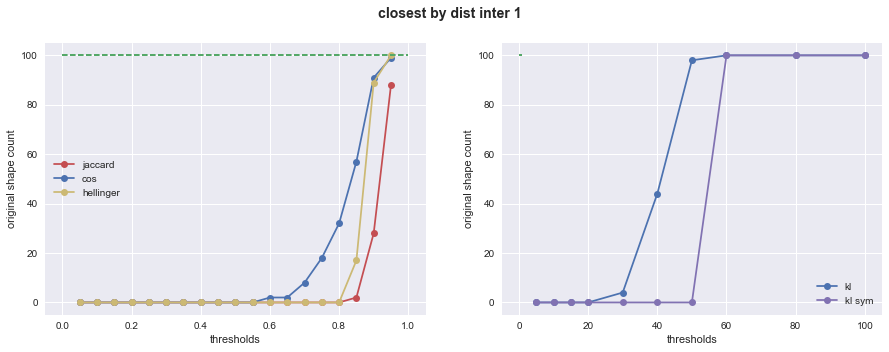

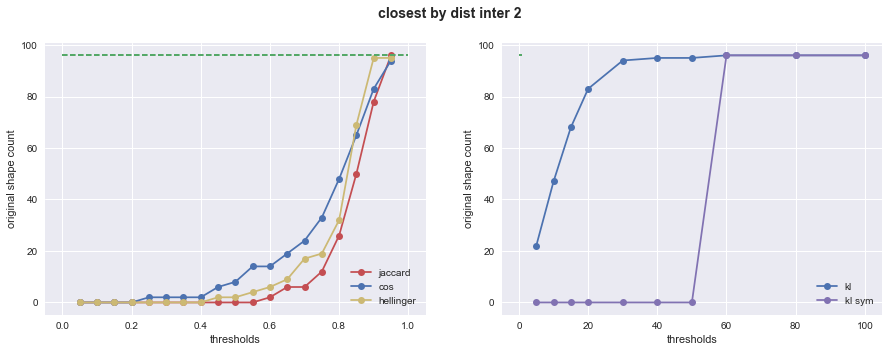

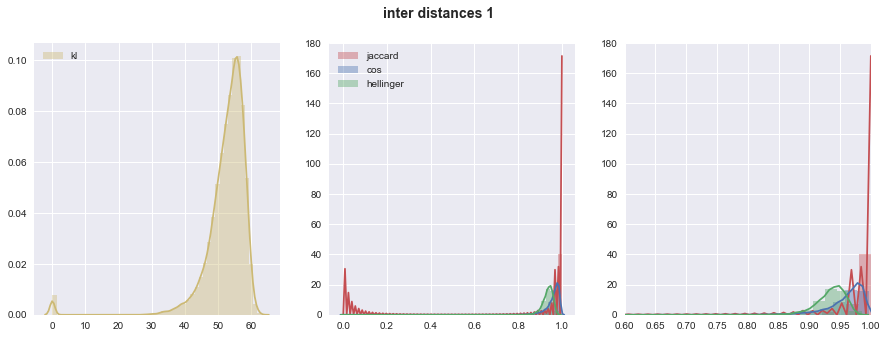

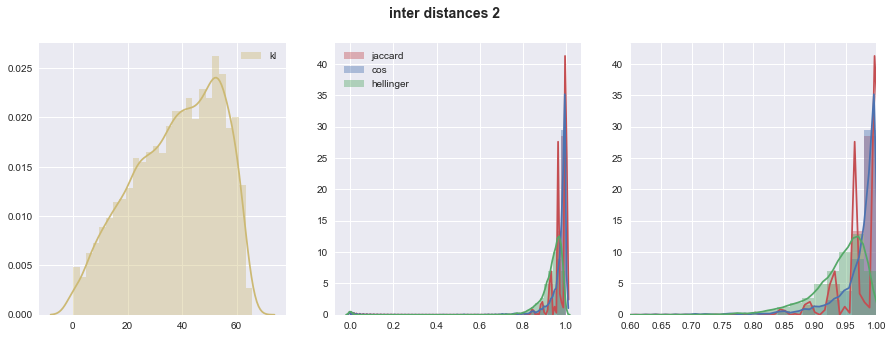

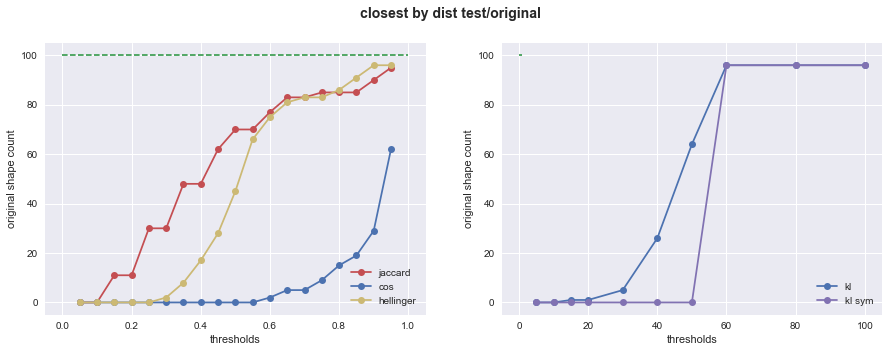

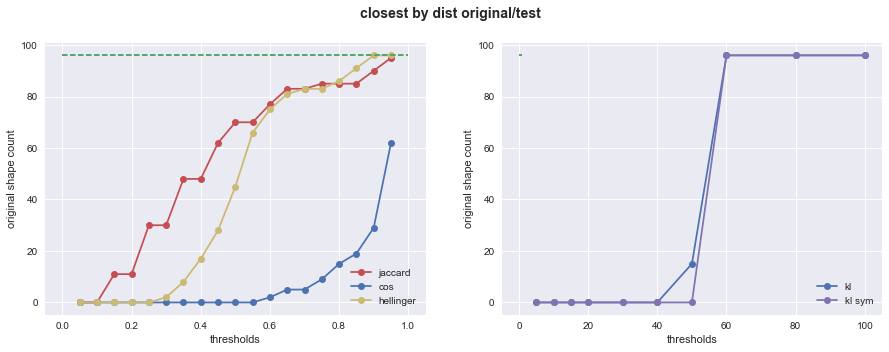

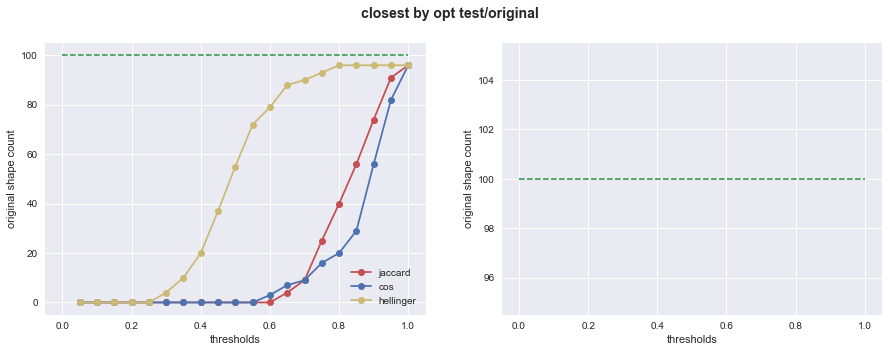

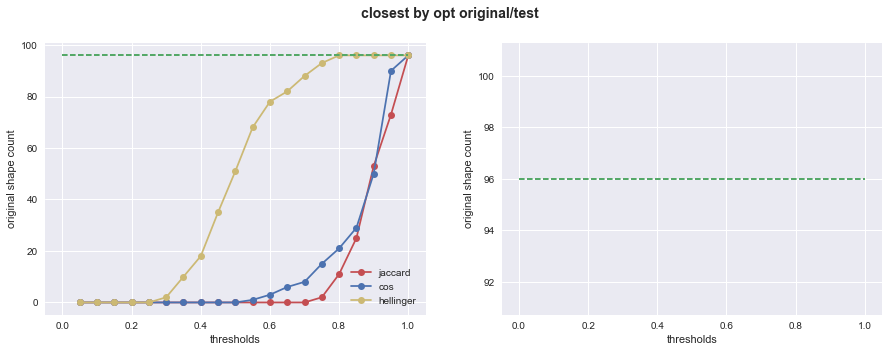

In [28]:
def create_model_dtn_100(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 23
functions_list[idx] = create_model_dtn_100
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [13]:
idx = 23
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx],
        init_num_topics=100,
        first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
create_model_dtn_100                     -            -            -        -
100 -> 96, 0.96                   24 vs 50  .63 vs 0.59  .78 vs 0.77    -----
closest by dist test/original       j11-h0      j48-h17      j77-h75  j85-h86
closest by dist original/test       j11-h0      j48-h17      j77-h75  j85-h86
closest by opt res test/original       jh0       j0-h20       j0-h79  j40-h96
closest by opt res original/test       jh0       j0-h18       j0-h78  j11-h96

name = create_model_dtn_150_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 138, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_47', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_61', u'topic_62', u'topic_63', u'topic_64', u'topic_65', u'topic_66', u'topic_67', u'topic_68', u'topi

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   138.00
non zero ratio                    0.96     0.96
|phi_ij == 0| / n_topics       7689.02  7749.54
|phi_ij > 0.2| / n_topics         0.03     0.54
|phi_ij > 0.1| / n_topics         0.31     1.41
|phi_ij > 0.01| / n_topics       14.64    20.22
|phi_ij > 0.05| / n_topics        1.21     3.49
|phi_ij > 0.001| / n_topics     214.17    72.59
topic_kernel_average_size        23.68    34.22
topic_kernel_average_purity       0.63     0.54
topic_kernel_average_contrast     0.78     0.71

Dist fn = <function kl_sym_dist at 0x000000000BD26908>, Processed th = 100, original columns count = 138        Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Dist fn = <function cos_dist at 0x000000000BD26A58>, Processed th = 1.0, original columns count = 100           Column topic_6 not optimized
Column topic_15 not optimized
Column topic_16 not optimized
Column topic_19 not optimized
Column topic_21 not optimized
Column topic_34 not optimized
Column topic_40 not optimized
Column topic_

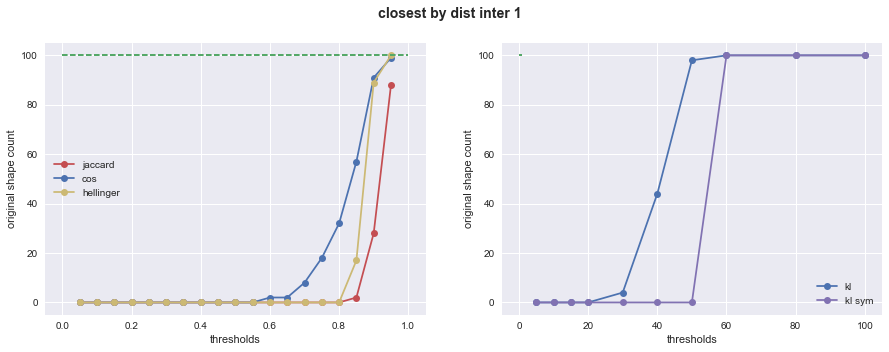

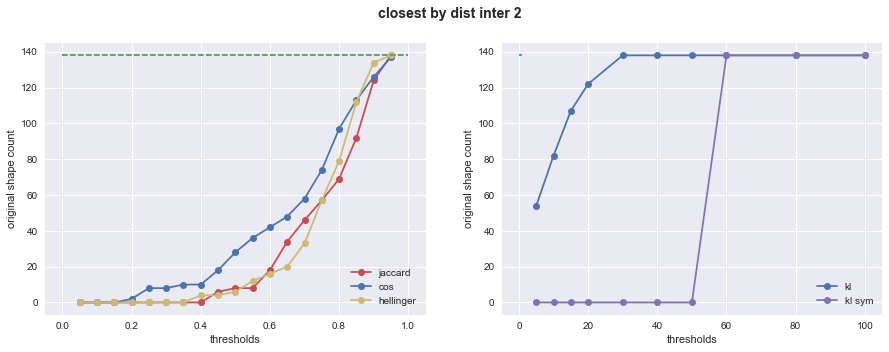

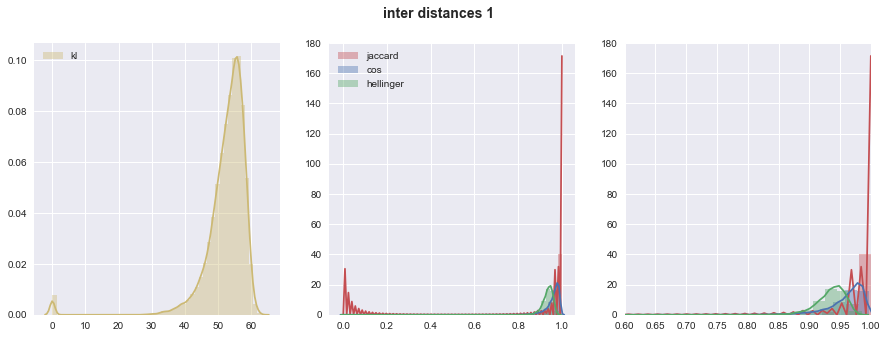

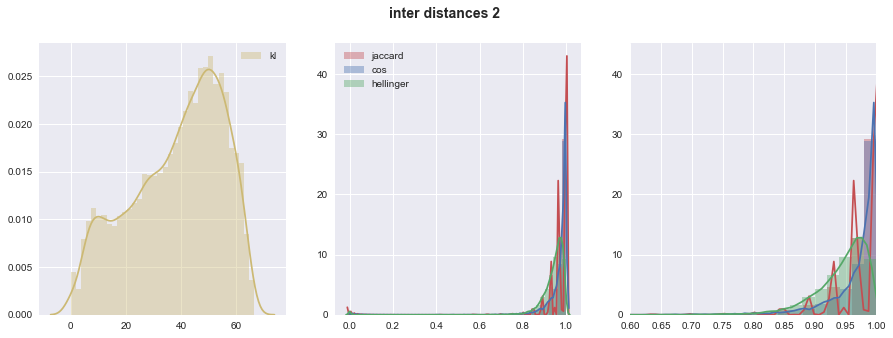

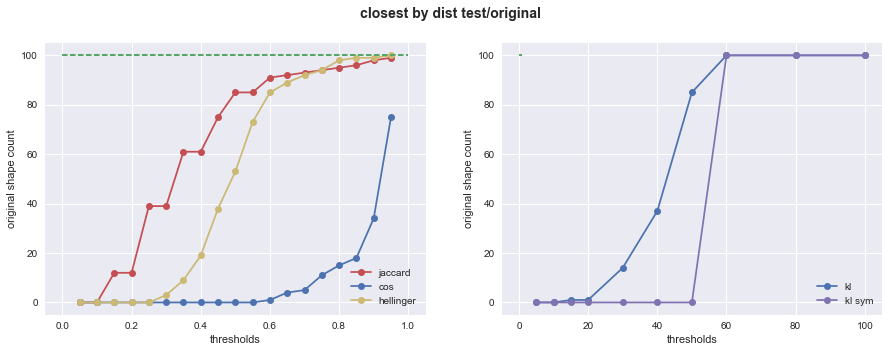

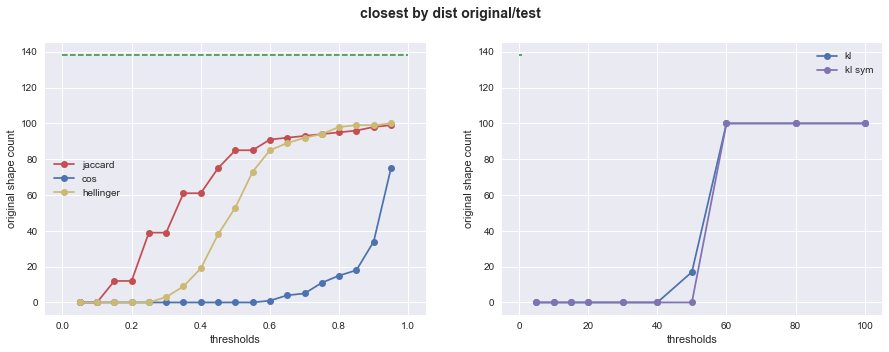

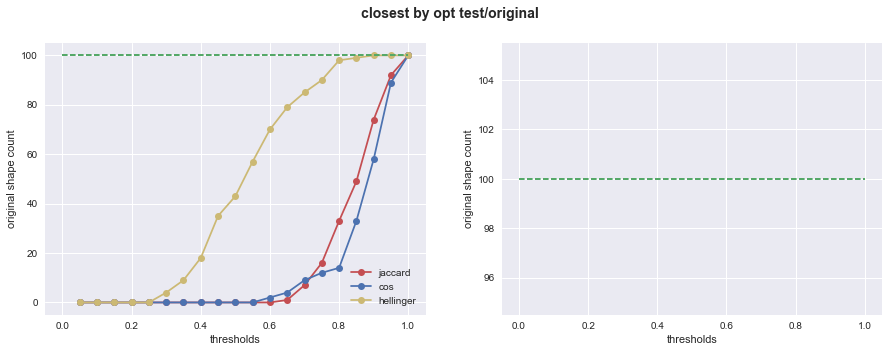

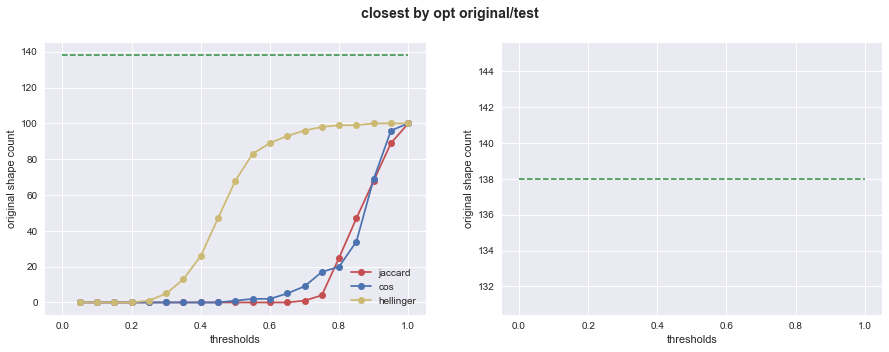

In [29]:
def create_model_dtn_150(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 24
functions_list[idx] = create_model_dtn_150
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [14]:
idx = 24
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx],
        init_num_topics=150,
        first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
create_model_dtn_150                     -            -            -        -
150 -> 138, 0.96                  24 vs 34  .63 vs 0.54  .78 vs 0.71    -----
closest by dist test/original       j12-h0      j61-h19      j91-h85  j95-h98
closest by dist original/test       j12-h0      j61-h19      j91-h85  j95-h98
closest by opt res test/original       jh0       j0-h18       j0-h70  j33-h98
closest by opt res original/test       jh0       j0-h26       j0-h89  j25-h99

name = create_model_dtn_200_iter_0, n_topics = 200, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 168, [u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_32', u'topic_33', u'topic_34', u'topic_37', u'topic_38', u'topic_39', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_58', u'topic_59', u'topic_61', u'topic_62', u'topic_63', u'topic_66', u'topic_67', u'topic_68', u'topic_69', u'topic_70', u'topic_71', u'topic_72', u'topic_73', u'topic_74', u'topic_75', u'to

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   168.00
non zero ratio                    0.96     0.96
|phi_ij == 0| / n_topics       7689.02  7759.82
|phi_ij > 0.2| / n_topics         0.03     0.60
|phi_ij > 0.1| / n_topics         0.31     1.45
|phi_ij > 0.01| / n_topics       14.64    20.09
|phi_ij > 0.05| / n_topics        1.21     3.53
|phi_ij > 0.001| / n_topics     214.17    70.00
topic_kernel_average_size        23.68    28.58
topic_kernel_average_purity       0.63     0.54
topic_kernel_average_contrast     0.78     0.70

Dist fn = <function kl_sym_dist at 0x000000000BD26908>, Processed th = 100, original columns count = 168        Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Dist fn = <function cos_dist at 0x000000000BD26A58>, Processed th = 1.0, original columns count = 100           Column topic_0 not optimized
Column topic_2 not optimized
Column topic_3 not optimized
Column topic_14 not optimized
Column topic_16 not optimized
Column topic_19 not optimized
Column topic_22 not optimized
Column topic_28

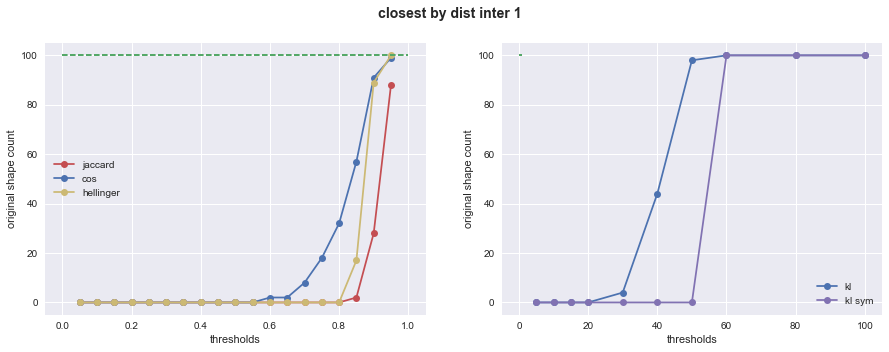

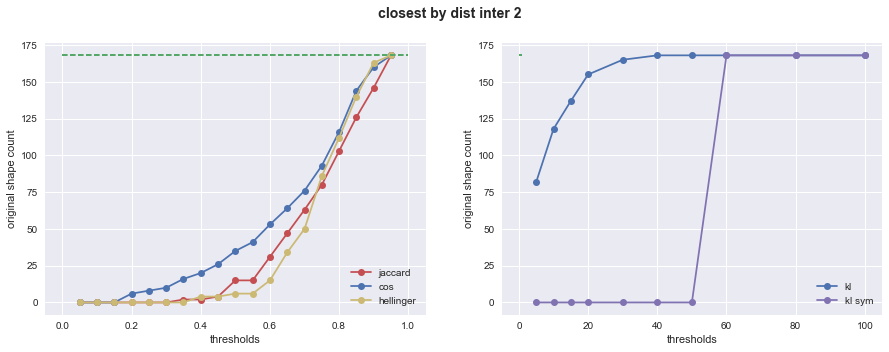

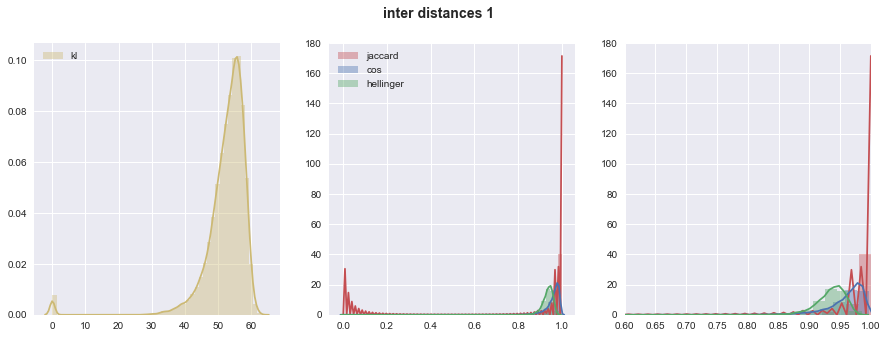

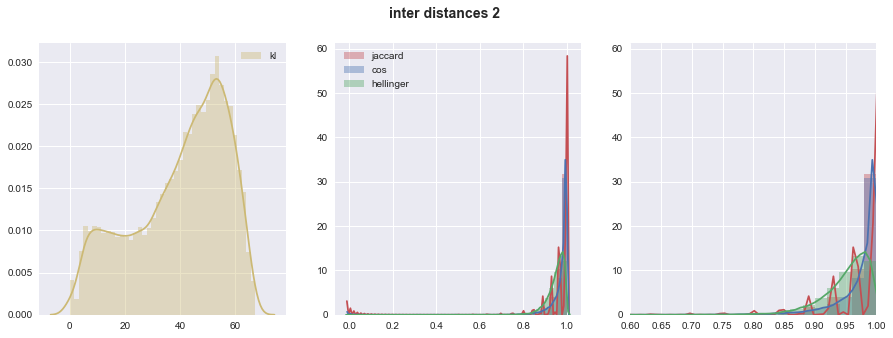

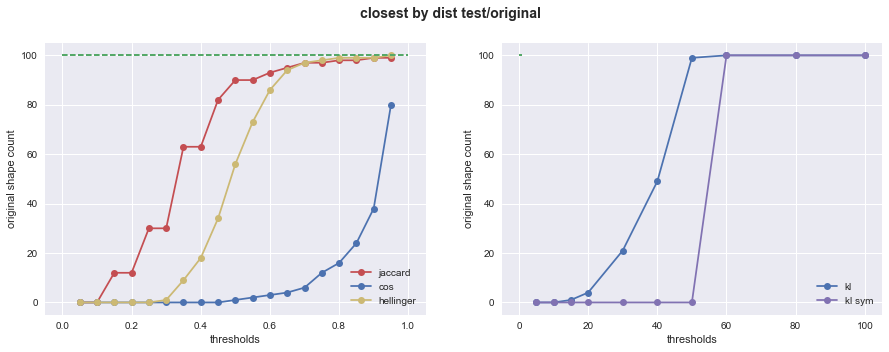

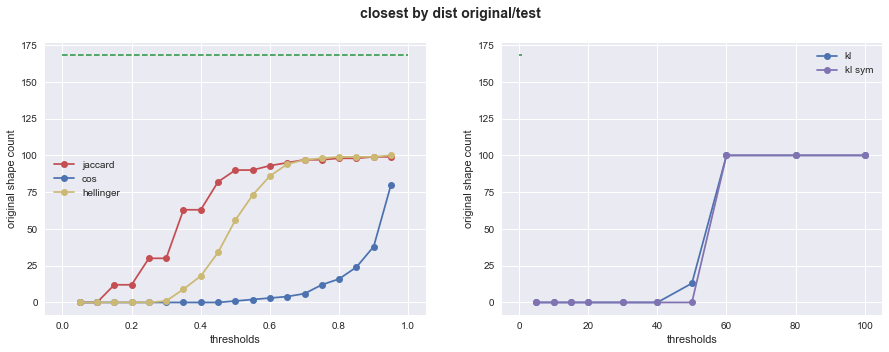

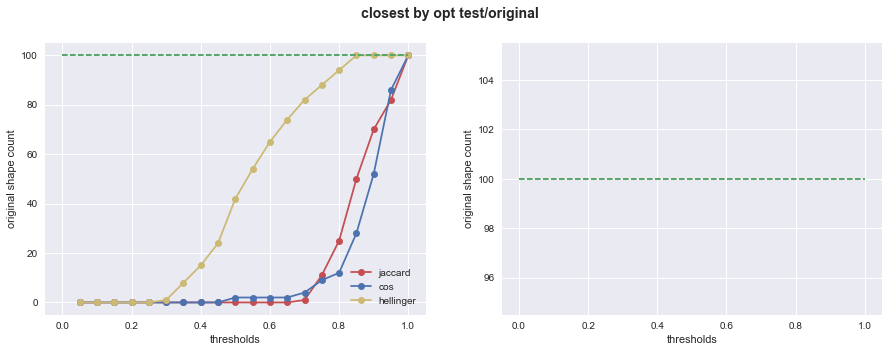

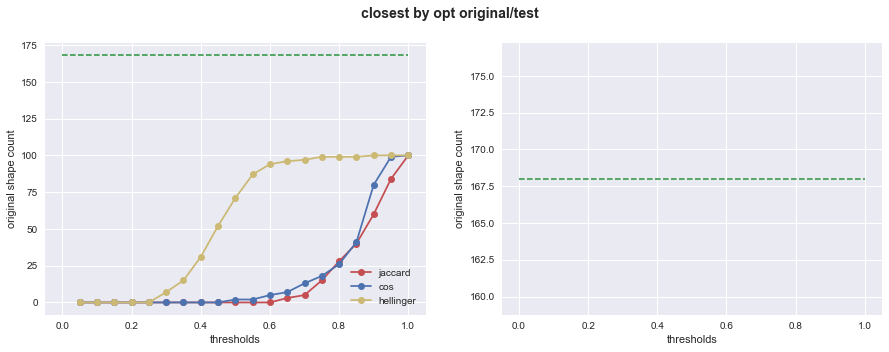

In [30]:
def create_model_dtn_200(n_iteration, model_name='', fit=True, n_topics=200):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 25
functions_list[idx] = create_model_dtn_200
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [15]:
idx = 25
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx],
        init_num_topics=200,
        first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
create_model_dtn_200                     -            -            -        -
200 -> 168, 0.96                  24 vs 29  .63 vs 0.54  .78 vs 0.70    -----
closest by dist test/original       j12-h0      j63-h18      j93-h86  j98-h99
closest by dist original/test       j12-h0      j63-h18      j93-h86  j98-h99
closest by opt res test/original       jh0       j0-h15       j0-h65  j25-h94
closest by opt res original/test       jh0       j0-h31       j0-h94  j28-h99

name = create_model_dtn_250_iter_0, n_topics = 250, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 192, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_19', u'topic_22', u'topic_23', u'topic_24', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_55', u'topic_56', u'topic_58', u'topic_59', u'topic_61', u'topic_62', u'topic_63', u'topic_64', u'topic_66', u'topic_67', u'topic_68', u'topic_69', u'topic_70', u'topic_71', u'topic_72', u'topic_73', u'topic_75', u'top

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   192.00
non zero ratio                    0.96     0.96
|phi_ij == 0| / n_topics       7689.02  7763.90
|phi_ij > 0.2| / n_topics         0.03     0.53
|phi_ij > 0.1| / n_topics         0.31     1.31
|phi_ij > 0.01| / n_topics       14.64    20.95
|phi_ij > 0.05| / n_topics        1.21     3.46
|phi_ij > 0.001| / n_topics     214.17    69.90
topic_kernel_average_size        23.68    24.92
topic_kernel_average_purity       0.63     0.52
topic_kernel_average_contrast     0.78     0.68

Dist fn = <function kl_sym_dist at 0x000000000BD26908>, Processed th = 100, original columns count = 192        Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Dist fn = <function cos_dist at 0x000000000BD26A58>, Processed th = 1.0, original columns count = 100           Column topic_92 not optimized
Dist fn = <function cos_dist at 0x000000000BD26A58>, Processed th = 1.0, original columns count = 100           Column topic_0 not optimized
Column topic_14 not optimized
Column topic_15 not o

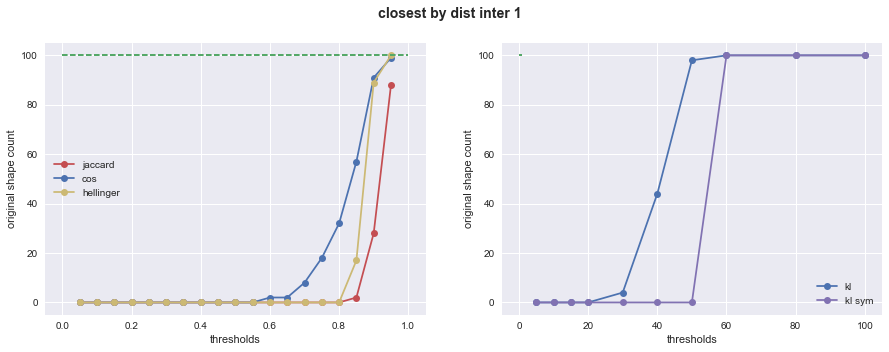

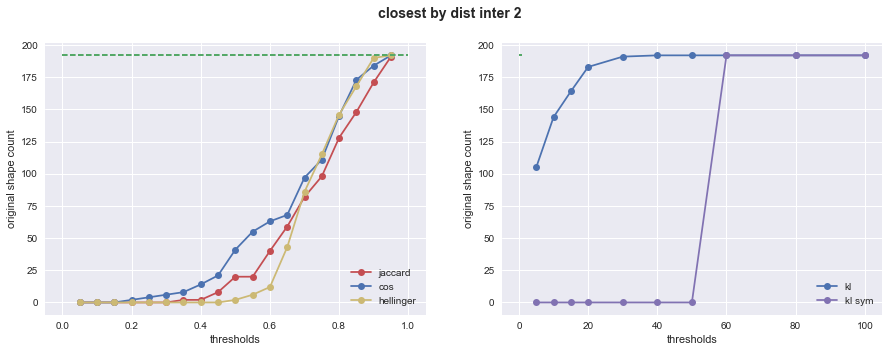

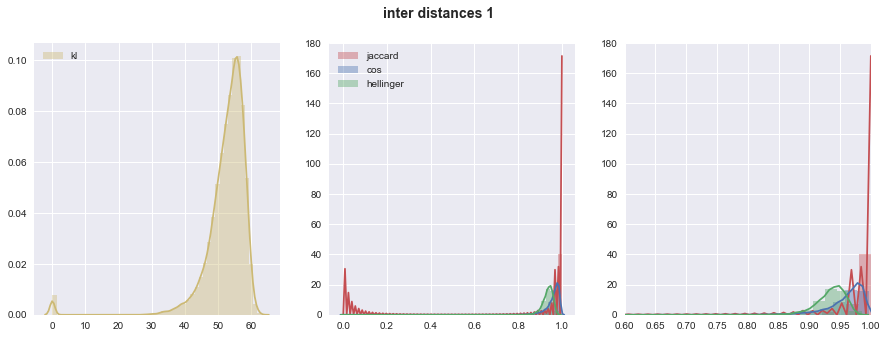

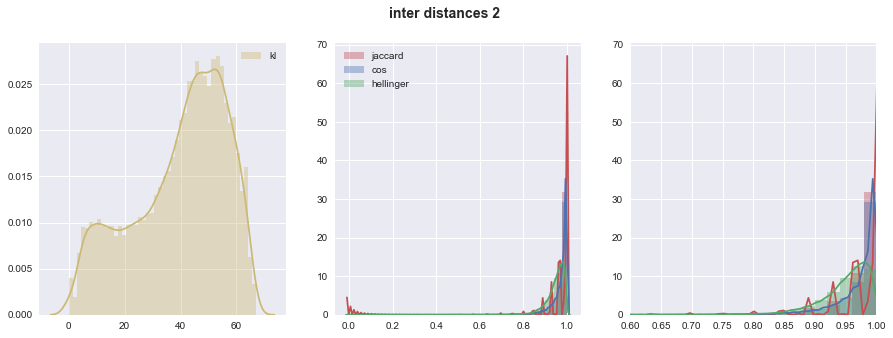

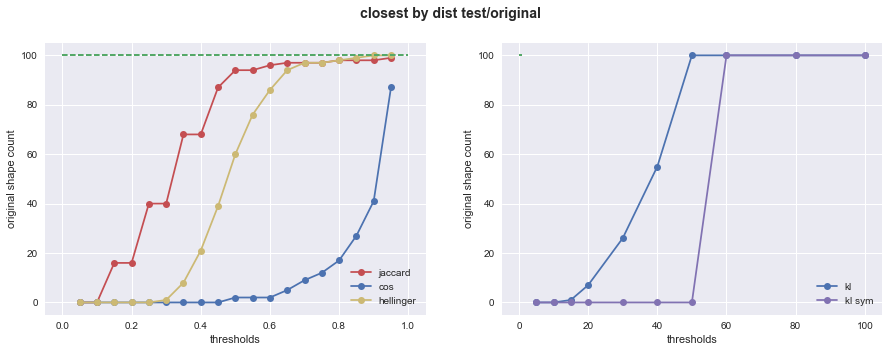

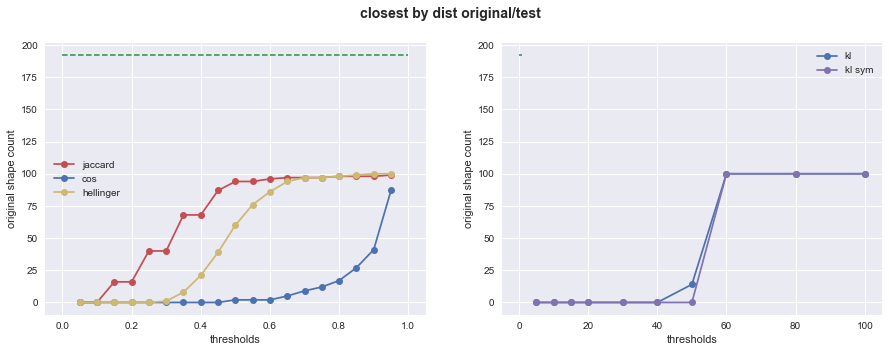

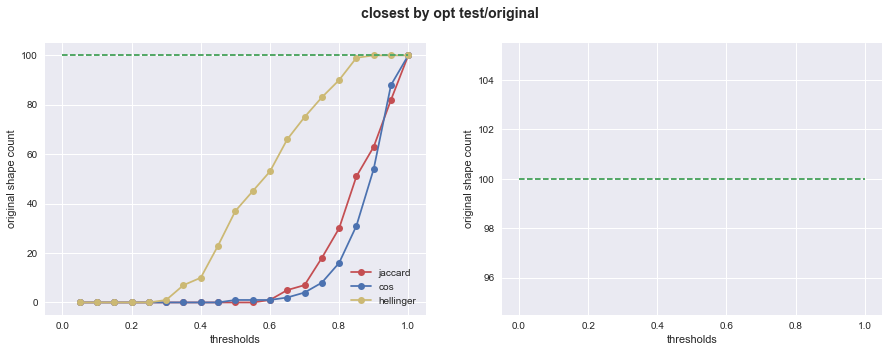

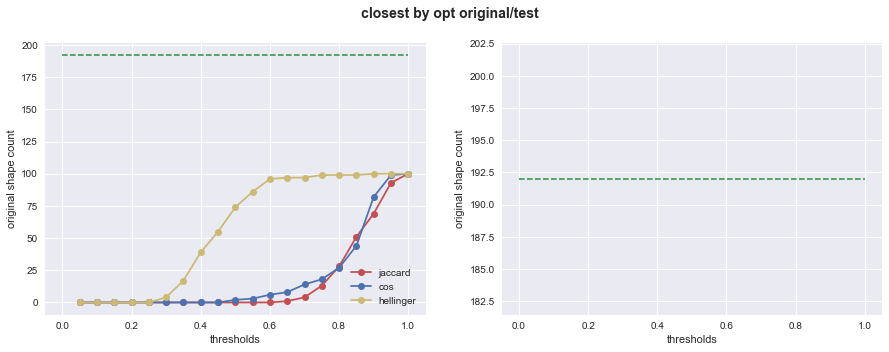

In [31]:
def create_model_dtn_250(n_iteration, model_name='', fit=True, n_topics=250):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 26
functions_list[idx] = create_model_dtn_250
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [16]:
idx = 26
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx],
        init_num_topics=250,
        first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
create_model_dtn_250                     -            -            -        -
250 -> 192, 0.96                  24 vs 25  .63 vs 0.52  .78 vs 0.68    -----
closest by dist test/original       j16-h0      j68-h21      j96-h86     jh98
closest by dist original/test       j16-h0      j68-h21      j96-h86     jh98
closest by opt res test/original       jh0       j0-h10       j1-h53  j30-h90
closest by opt res original/test       jh0       j0-h39       j0-h96  j28-h99

name = create_model_dtn_300_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 214, [u'topic_0', u'topic_1', u'topic_3', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_19', u'topic_22', u'topic_23', u'topic_24', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_41', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_52', u'topic_53', u'topic_55', u'topic_56', u'topic_59', u'topic_61', u'topic_62', u'topic_63', u'topic_64', u'topic_65', u'topic_66', u'topic_67', u'topic_68', u'topic_69', u'topic_70', u'topic_71', u'topic_72', u'topic_73', u'topic_75', u'topic_76', u'topic_77', u'topic_78', u'topic_80', u'to

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   214.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       7689.02  7770.50
|phi_ij > 0.2| / n_topics         0.03     0.52
|phi_ij > 0.1| / n_topics         0.31     1.40
|phi_ij > 0.01| / n_topics       14.64    20.58
|phi_ij > 0.05| / n_topics        1.21     3.59
|phi_ij > 0.001| / n_topics     214.17    67.76
topic_kernel_average_size        23.68    22.21
topic_kernel_average_purity       0.63     0.51
topic_kernel_average_contrast     0.78     0.68

Dist fn = <function kl_sym_dist at 0x000000000BD26908>, Processed th = 100, original columns count = 214        Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Dist fn = <function cos_dist at 0x000000000BD26A58>, Processed th = 1.0, original columns count = 100           Column topic_5 not optimized
Column topic_6 not optimized
Column topic_16 not optimized
Column topic_21 not optimized
Column topic_24 not optimized
Column topic_26 not optimized
Column topic_28 not optimized
Column topic_3

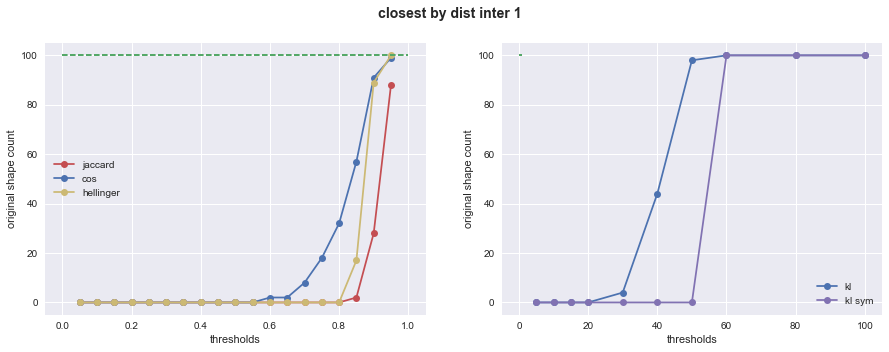

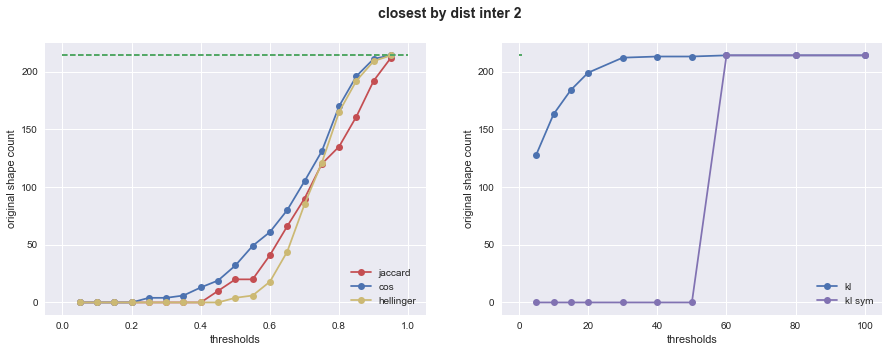

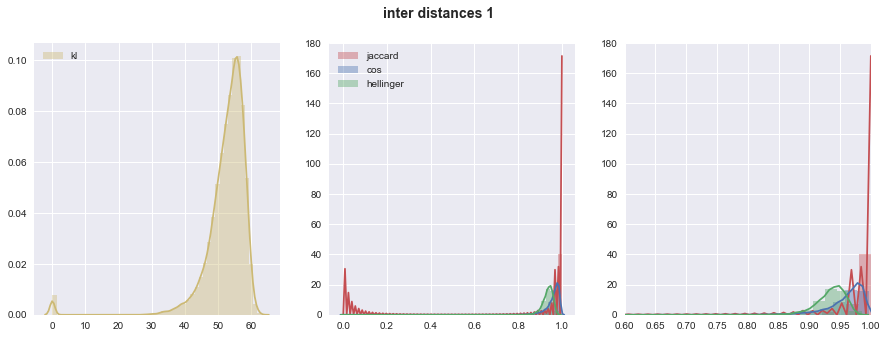

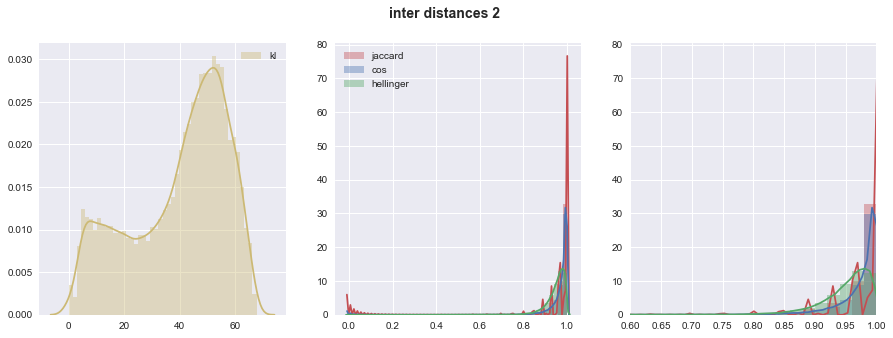

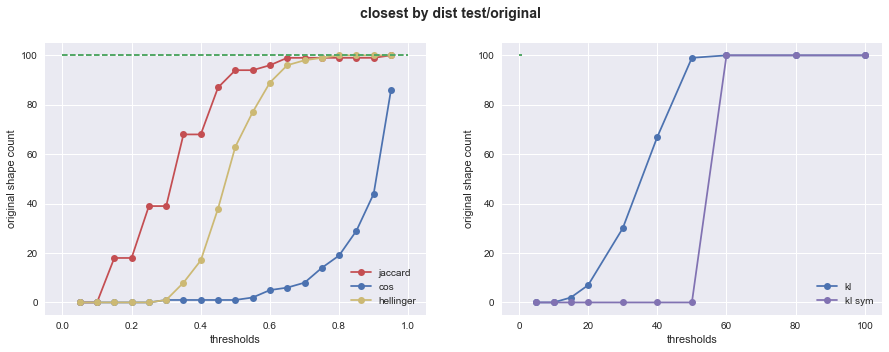

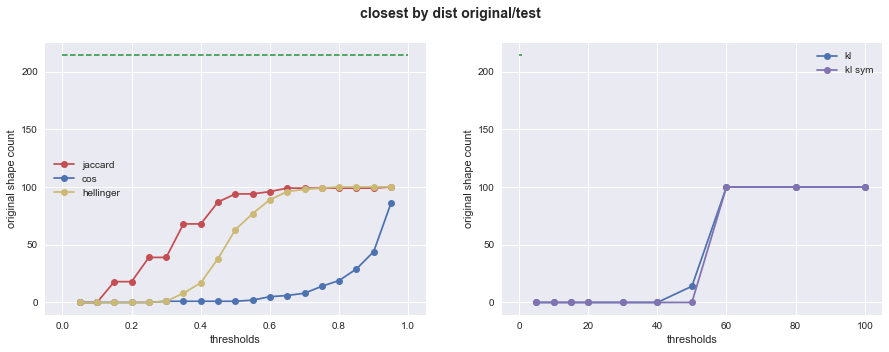

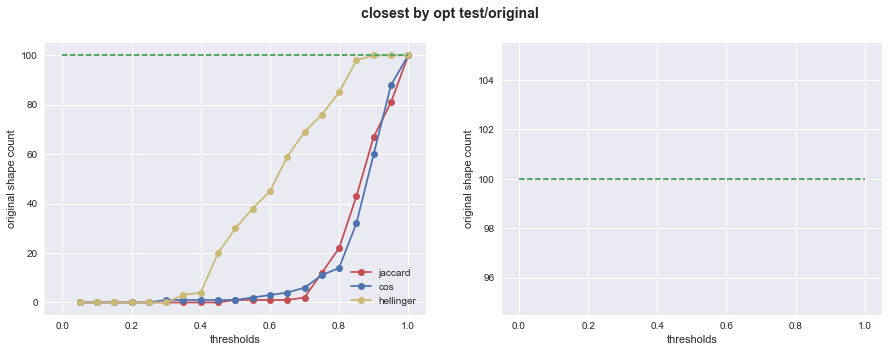

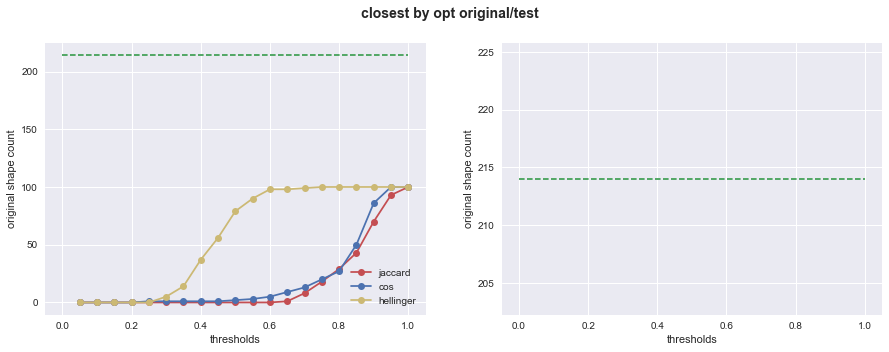

In [32]:
def create_model_dtn_300(n_iteration, model_name='', fit=True, n_topics=300):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 27
functions_list[idx] = create_model_dtn_300
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [17]:
idx = 27
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx],
        init_num_topics=300,
        first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6       0.8
create_model_dtn_300                     -            -            -         -
300 -> 214, 0.97                  24 vs 22  .63 vs 0.51  .78 vs 0.68     -----
closest by dist test/original       j18-h0      j68-h17      j96-h89  j99-h100
closest by dist original/test       j18-h0      j68-h17      j96-h89  j99-h100
closest by opt res test/original       jh0        j0-h4       j1-h45   j22-h85
closest by opt res original/test       jh0       j0-h37       j0-h98  j29-h100

name = create_model_dtn_350_iter_0, n_topics = 350, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 242, [u'topic_0', u'topic_1', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_41', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_55', u'topic_59', u'topic_61', u'topic_62', u'topic_63', u'topic_64', u'topic_66', u'topic_67', u'topic_68', u'topic_69', u'topic_70', u'topic_71', u'topic_72', u'topic_73', u'topic_75', u'topic_76', u'topic_78', u'topic_80', u'topic_81', u'topic_82', u'topic_83', u'topic_85', u't

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   242.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       7689.02  7772.53
|phi_ij > 0.2| / n_topics         0.03     0.56
|phi_ij > 0.1| / n_topics         0.31     1.45
|phi_ij > 0.01| / n_topics       14.64    19.99
|phi_ij > 0.05| / n_topics        1.21     3.50
|phi_ij > 0.001| / n_topics     214.17    64.26
topic_kernel_average_size        23.68    19.69
topic_kernel_average_purity       0.63     0.50
topic_kernel_average_contrast     0.78     0.65

Dist fn = <function kl_sym_dist at 0x000000000BD26908>, Processed th = 100, original columns count = 242        Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Dist fn = <function cos_dist at 0x000000000BD26A58>, Processed th = 1.0, original columns count = 100           Column topic_17 not optimized
Column topic_35 not optimized
Column topic_38 not optimized
Column topic_41 not optimized
Column topic_44 not optimized
Column topic_47 not optimized
Column topic_49 not optimized
Column topic

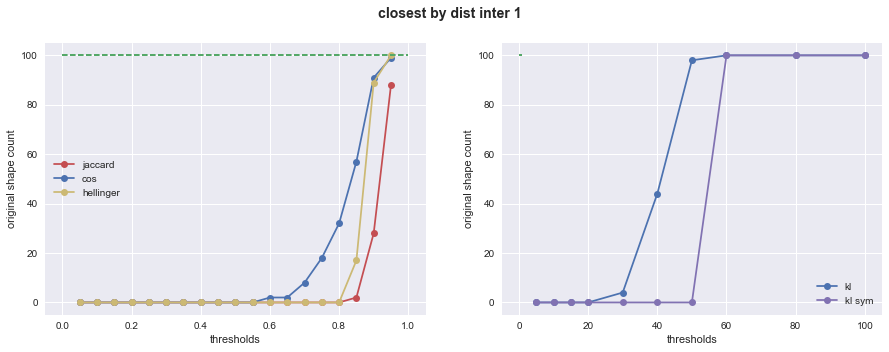

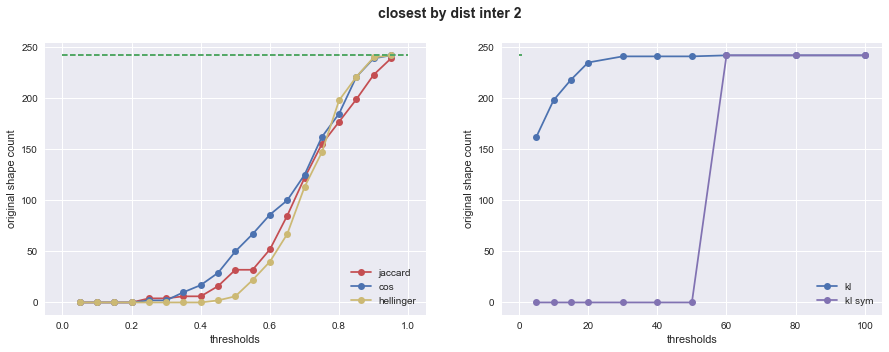

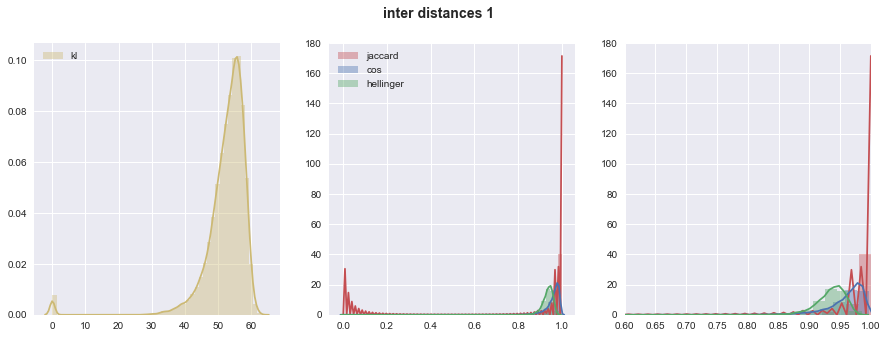

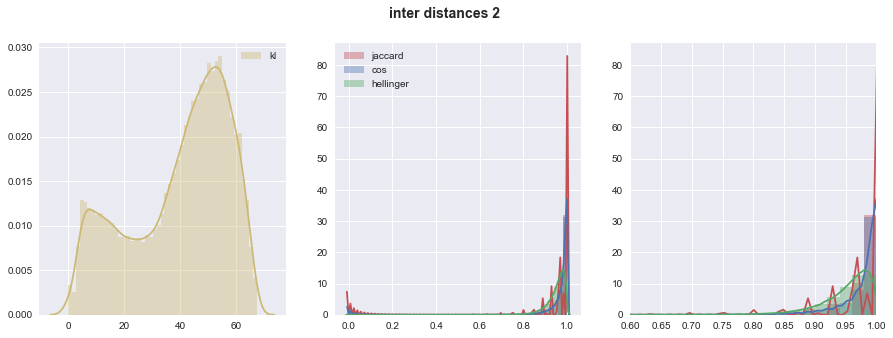

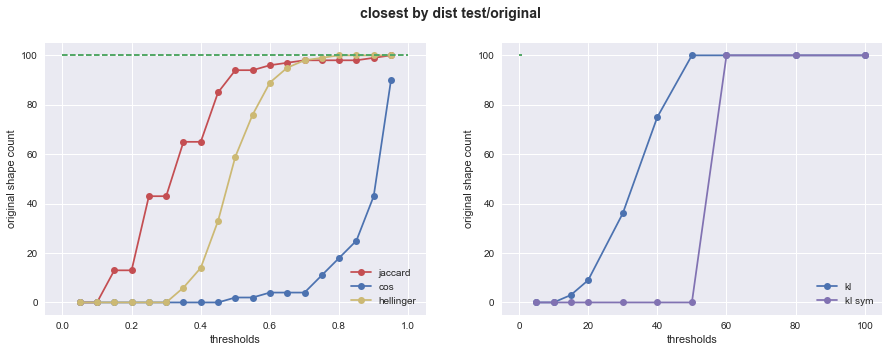

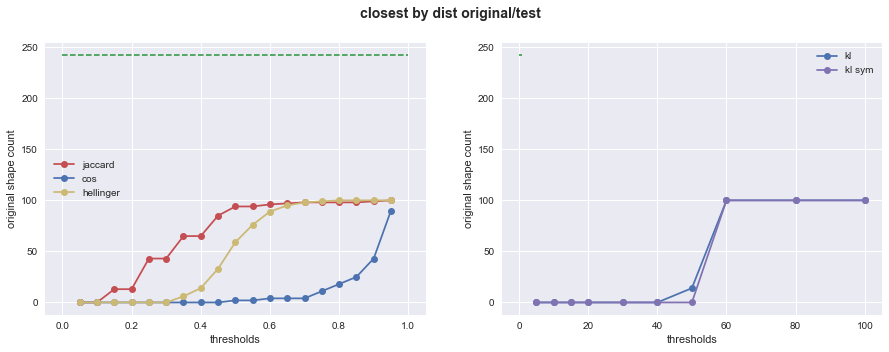

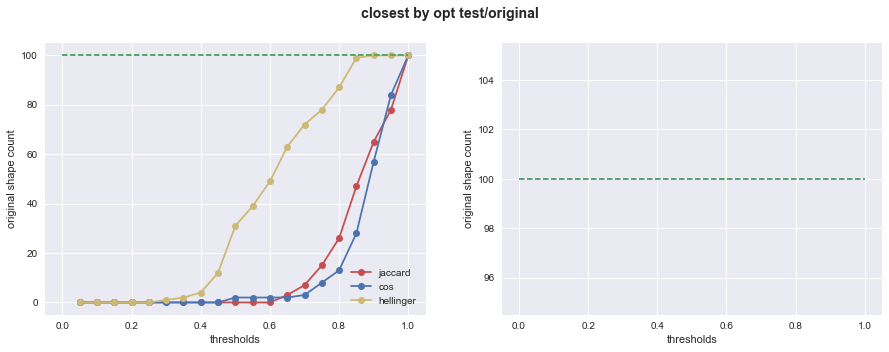

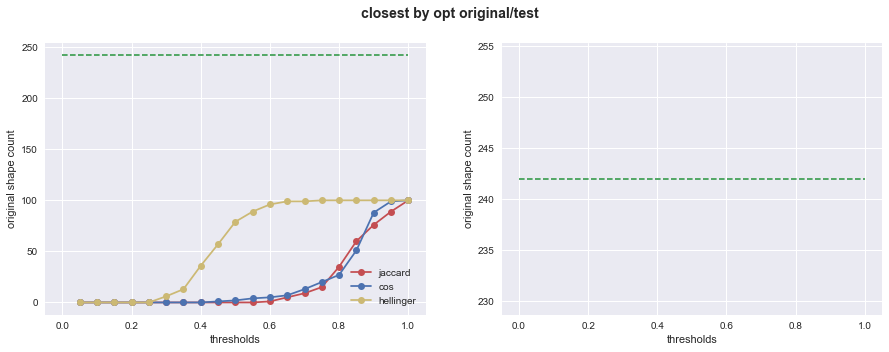

In [33]:
def create_model_dtn_350(n_iteration, model_name='', fit=True, n_topics=350):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 28
functions_list[idx] = create_model_dtn_350
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [18]:
idx = 28
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx],
        init_num_topics=350,
        first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6       0.8
create_model_dtn_350                     -            -            -         -
350 -> 242, 0.97                  24 vs 20  .63 vs 0.50  .78 vs 0.65     -----
closest by dist test/original       j13-h0      j65-h14      j96-h89  j98-h100
closest by dist original/test       j13-h0      j65-h14      j96-h89  j98-h100
closest by opt res test/original       jh0        j0-h4       j0-h49   j26-h87
closest by opt res original/test       jh0       j0-h36       j1-h96  j35-h100

name = create_model_dtn_400_iter_0, n_topics = 400, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 262, [u'topic_1', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_11', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_41', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_50', u'topic_52', u'topic_53', u'topic_55', u'topic_59', u'topic_60', u'topic_61', u'topic_63', u'topic_64', u'topic_66', u'topic_67', u'topic_68', u'topic_69', u'topic_70', u'topic_71', u'topic_72', u'topic_73', u'topic_75', u'topic_76', u'topic_78', u'topic_79', u'topic_80', u'topic_81', u'topic_82', u'topic_83', u'topic_85', u'topic_86', u't

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   262.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       7689.02  7775.25
|phi_ij > 0.2| / n_topics         0.03     0.53
|phi_ij > 0.1| / n_topics         0.31     1.37
|phi_ij > 0.01| / n_topics       14.64    20.27
|phi_ij > 0.05| / n_topics        1.21     3.42
|phi_ij > 0.001| / n_topics     214.17    64.75
topic_kernel_average_size        23.68    18.41
topic_kernel_average_purity       0.63     0.50
topic_kernel_average_contrast     0.78     0.63

Dist fn = <function kl_sym_dist at 0x000000000BD26908>, Processed th = 100, original columns count = 262        Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Dist fn = <function cos_dist at 0x000000000BD26A58>, Processed th = 1.0, original columns count = 100           Column topic_2 not optimized
Column topic_4 not optimized
Column topic_8 not optimized
Column topic_9 not optimized
Column topic_10 not optimized
Column topic_15 not optimized
Column topic_24 not optimized
Column topic_32 

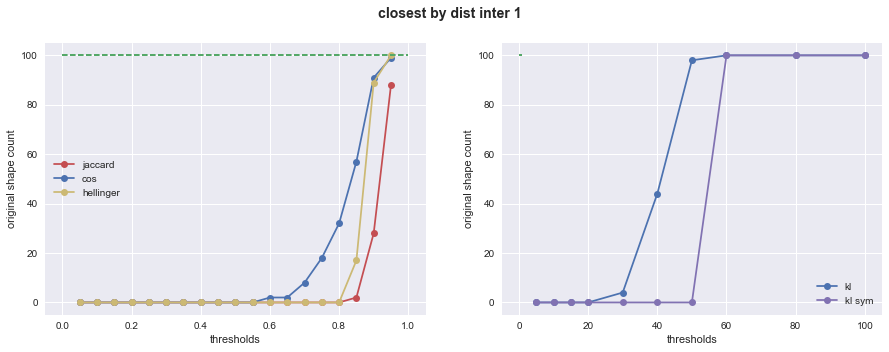

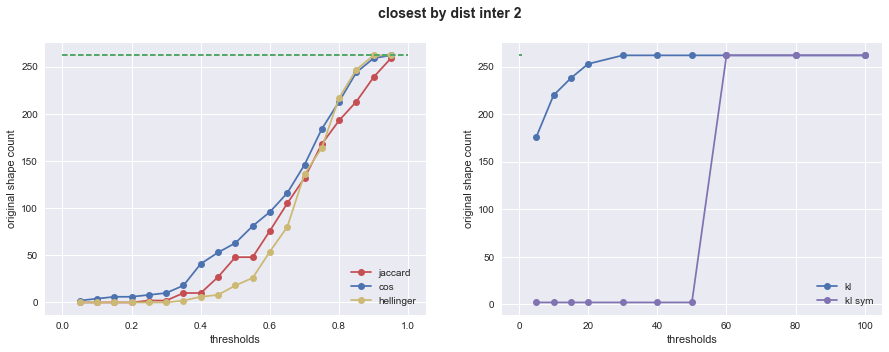

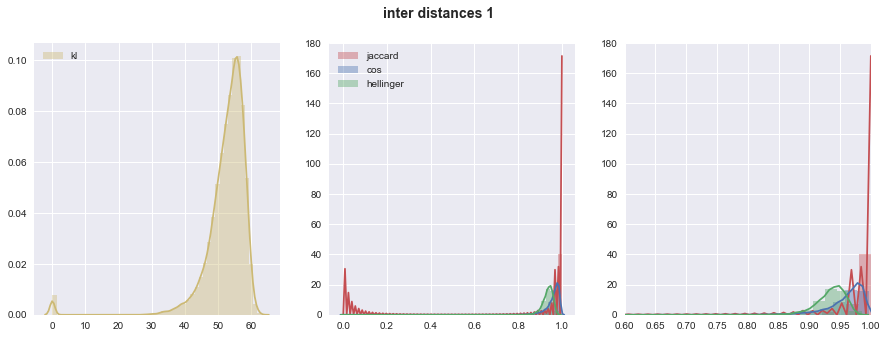

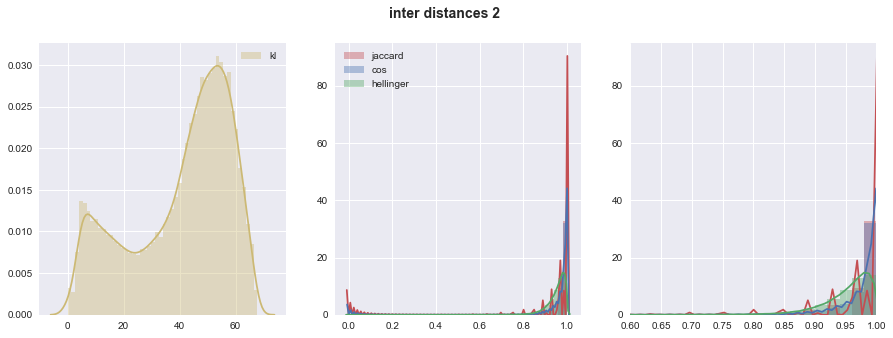

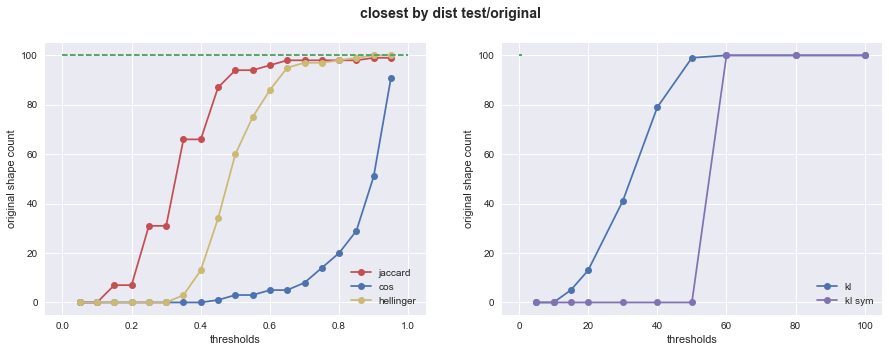

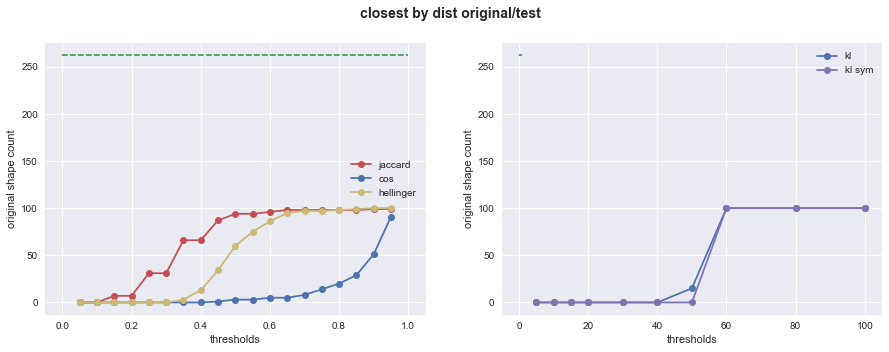

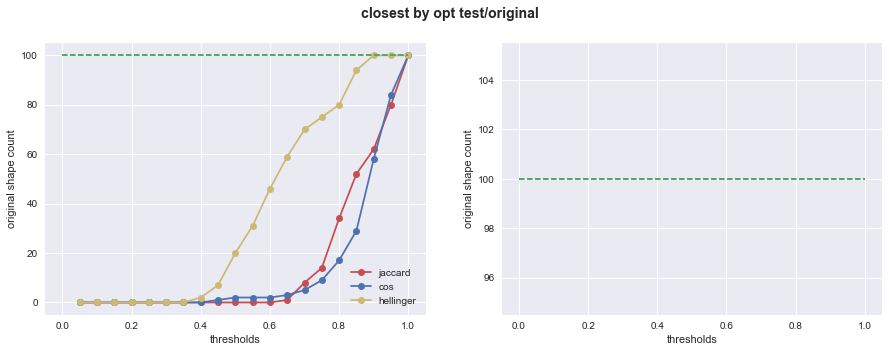

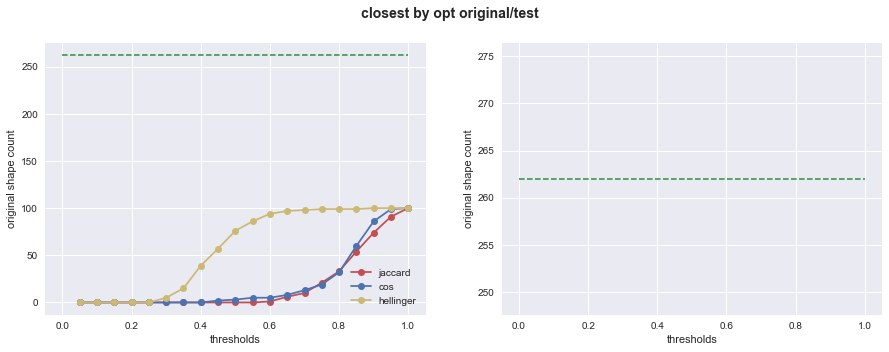

In [34]:
def create_model_dtn_400(n_iteration, model_name='', fit=True, n_topics=400):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 29
functions_list[idx] = create_model_dtn_400
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [19]:
idx = 29
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx],
        init_num_topics=400,
        first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
create_model_dtn_400                     -            -            -        -
400 -> 262, 0.97                  24 vs 18  .63 vs 0.50  .78 vs 0.63    -----
closest by dist test/original        j7-h0      j66-h13      j96-h86     jh98
closest by dist original/test        j7-h0      j66-h13      j96-h86     jh98
closest by opt res test/original       jh0        j0-h2       j0-h46  j34-h80
closest by opt res original/test       jh0       j0-h39       j1-h94  j33-h99

name = create_model_dtn_500_iter_0, n_topics = 500, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 314, [u'topic_0', u'topic_1', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_11', u'topic_12', u'topic_15', u'topic_16', u'topic_18', u'topic_19', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_32', u'topic_33', u'topic_34', u'topic_37', u'topic_38', u'topic_39', u'topic_41', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_49', u'topic_50', u'topic_52', u'topic_53', u'topic_55', u'topic_56', u'topic_59', u'topic_60', u'topic_61', u'topic_63', u'topic_64', u'topic_66', u'topic_67', u'topic_68', u'topic_69', u'topic_70', u'topic_71', u'topic_73', u'topic_74', u'topic_75', u'topic_76', u'topic_78', u'topic_79', u'topic_81', u'topic_83', u'topic_84', u'topic_85', u'topic_86', u'topic_87', u'to

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   314.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       7689.02  7779.76
|phi_ij > 0.2| / n_topics         0.03     0.57
|phi_ij > 0.1| / n_topics         0.31     1.41
|phi_ij > 0.01| / n_topics       14.64    19.50
|phi_ij > 0.05| / n_topics        1.21     3.48
|phi_ij > 0.001| / n_topics     214.17    57.49
topic_kernel_average_size        23.68    15.23
topic_kernel_average_purity       0.63     0.48
topic_kernel_average_contrast     0.78     0.60

Dist fn = <function kl_sym_dist at 0x000000000BD26908>, Processed th = 100, original columns count = 314        Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Dist fn = <function cos_dist at 0x000000000BD26A58>, Processed th = 1.0, original columns count = 100           Column topic_5 not optimized
Column topic_17 not optimized
Column topic_21 not optimized
Column topic_26 not optimized
Column topic_34 not optimized
Column topic_48 not optimized
Column topic_49 not optimized
Column topic_

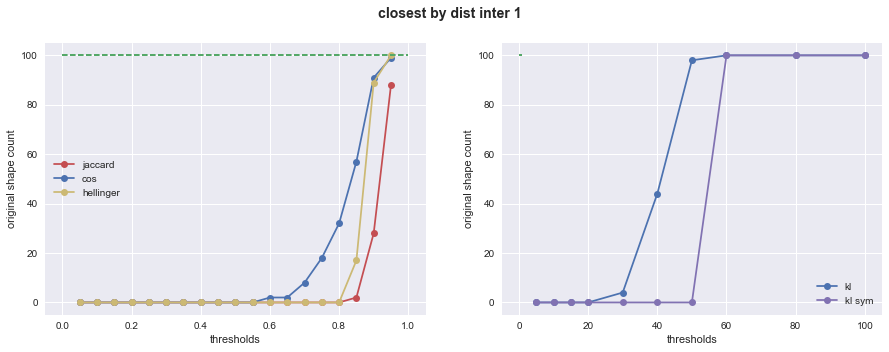

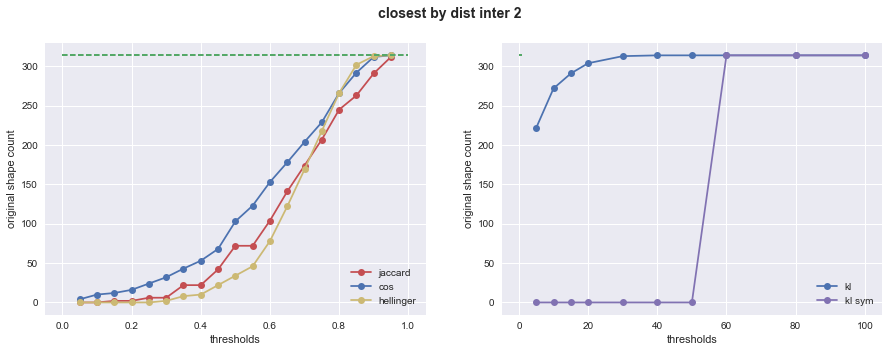

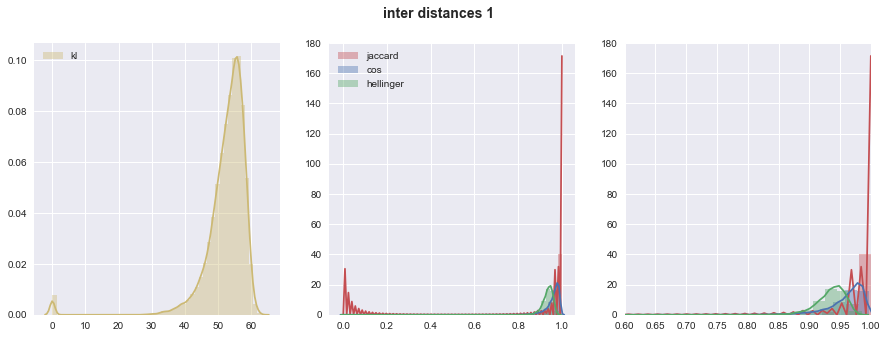

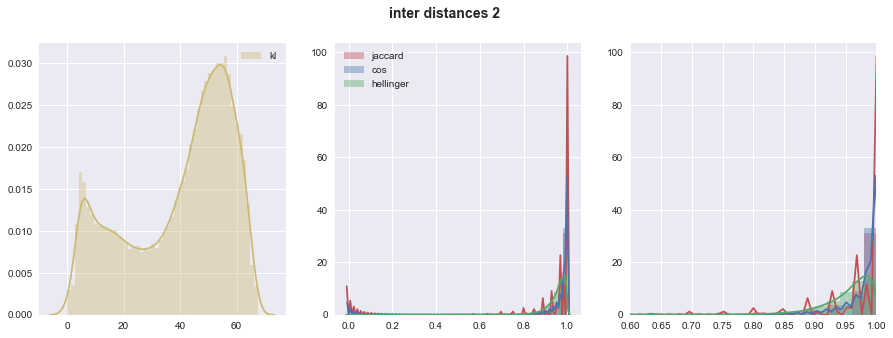

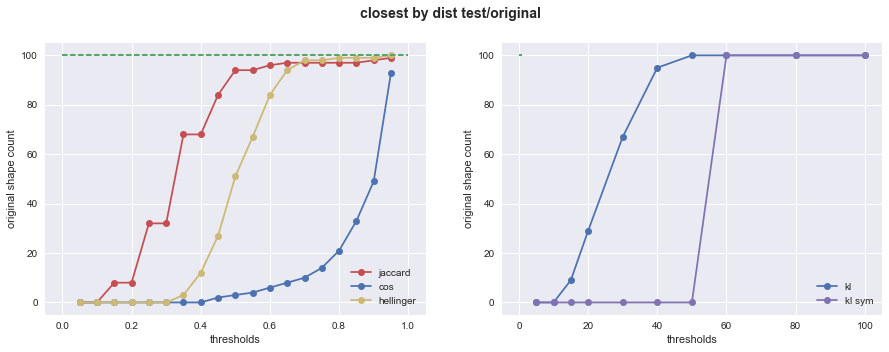

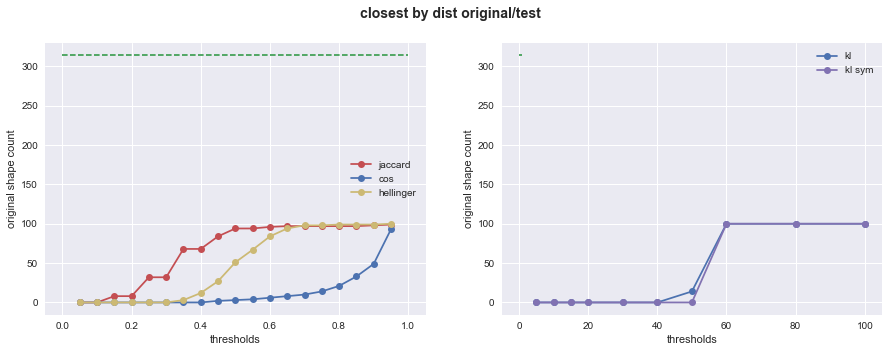

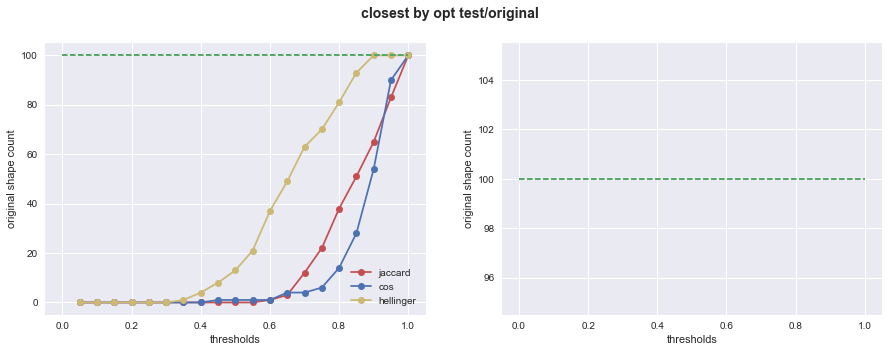

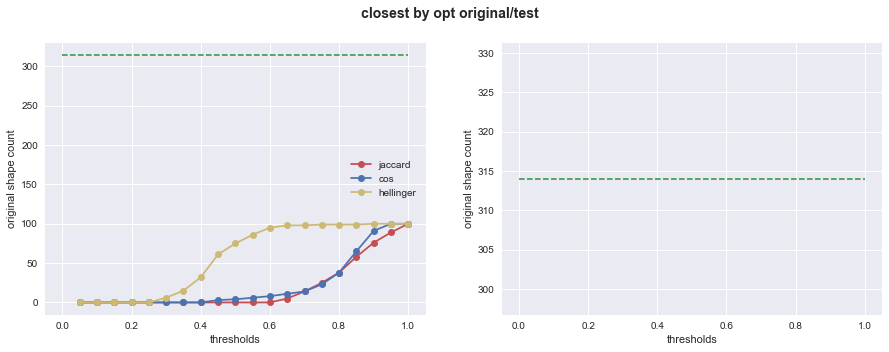

In [35]:
def create_model_dtn_500(n_iteration, model_name='', fit=True, n_topics=500):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 30
functions_list[idx] = create_model_dtn_500
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [20]:
idx = 30
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx],
        init_num_topics=500,
        first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6      0.8
create_model_dtn_500                     -            -            -        -
500 -> 314, 0.97                  24 vs 15  .63 vs 0.48  .78 vs 0.60    -----
closest by dist test/original        j8-h0      j68-h12      j96-h84  j97-h99
closest by dist original/test        j8-h0      j68-h12      j96-h84  j97-h99
closest by opt res test/original       jh0        j0-h4       j1-h37  j38-h81
closest by opt res original/test       jh0       j0-h32       j0-h95  j38-h99

name = create_model_dtn_750_iter_0, n_topics = 750, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 439, [u'topic_1', u'topic_2', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_11', u'topic_12', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_36', u'topic_37', u'topic_39', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_49', u'topic_50', u'topic_52', u'topic_53', u'topic_55', u'topic_58', u'topic_59', u'topic_61', u'topic_62', u'topic_63', u'topic_64', u'topic_66', u'topic_68', u'topic_70', u'topic_71', u'topic_73', u'topic_74', u'topic_76', u'topic_78', u'topic_82', u'topic_83', u'topic_85', u'topic_86', u'topic_88', u'topic_89', u'topic_92', u'topic_95', u'to

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   439.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       7689.02  7786.03
|phi_ij > 0.2| / n_topics         0.03     0.64
|phi_ij > 0.1| / n_topics         0.31     1.51
|phi_ij > 0.01| / n_topics       14.64    18.47
|phi_ij > 0.05| / n_topics        1.21     3.72
|phi_ij > 0.001| / n_topics     214.17    53.42
topic_kernel_average_size        23.68    10.81
topic_kernel_average_purity       0.63     0.39
topic_kernel_average_contrast     0.78     0.49

Dist fn = <function kl_sym_dist at 0x000000000BD26908>, Processed th = 100, original columns count = 439        Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Dist fn = <function cos_dist at 0x000000000BD26A58>, Processed th = 1.0, original columns count = 100           Column topic_2 not optimized
Column topic_8 not optimized
Column topic_10 not optimized
Column topic_22 not optimized
Column topic_32 not optimized
Column topic_36 not optimized
Column topic_37 not optimized
Column topic_4

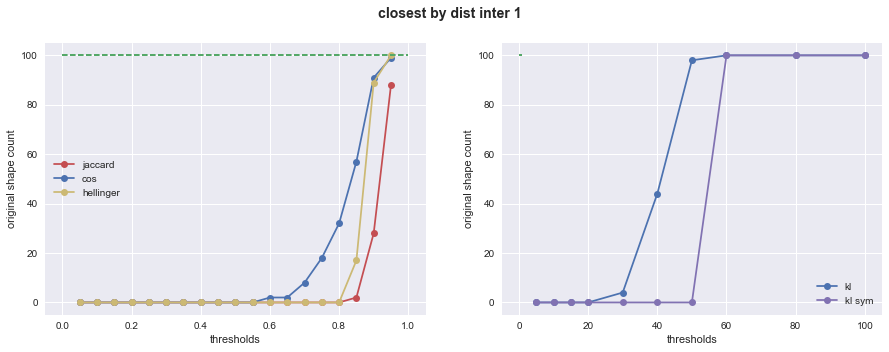

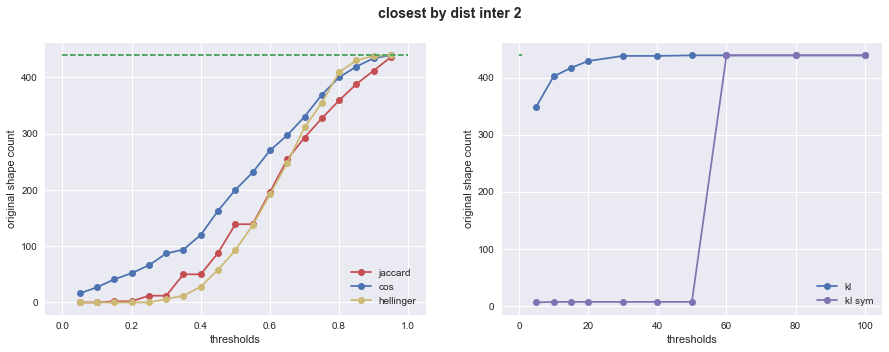

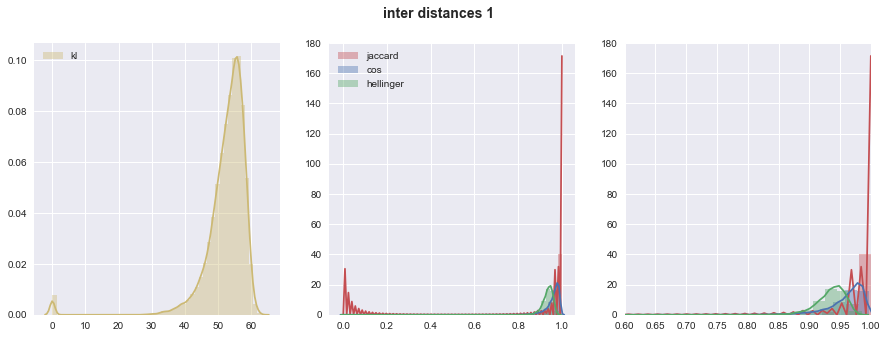

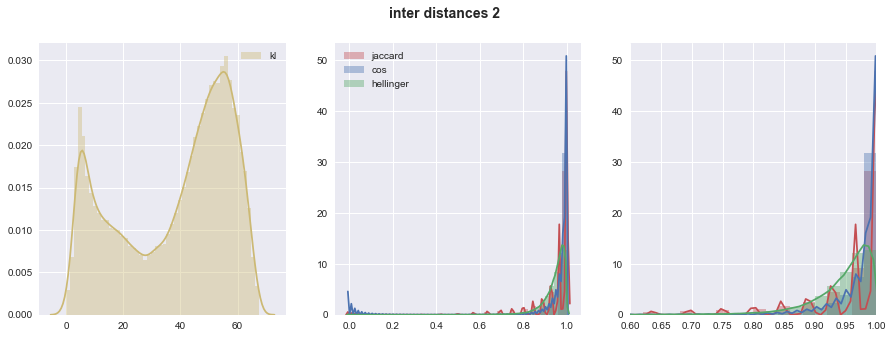

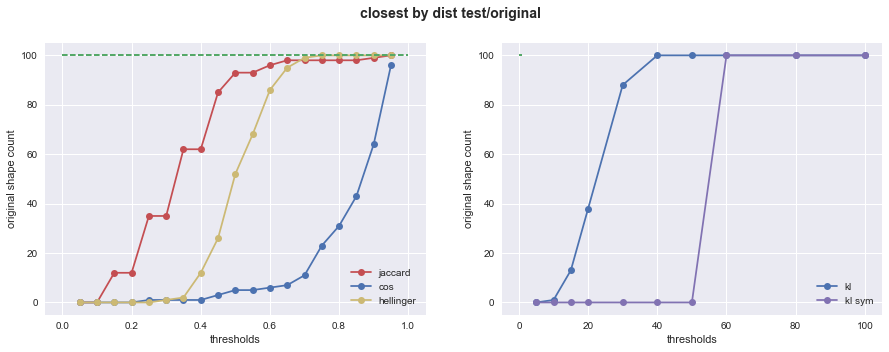

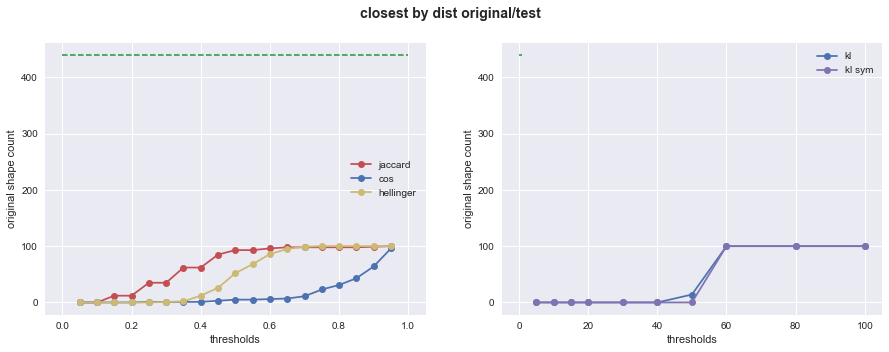

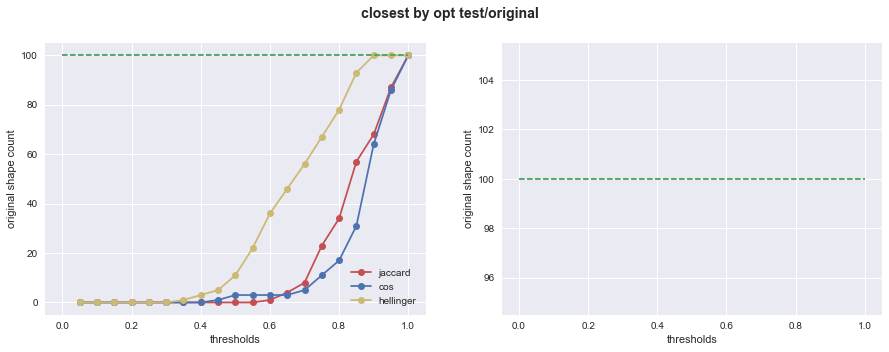

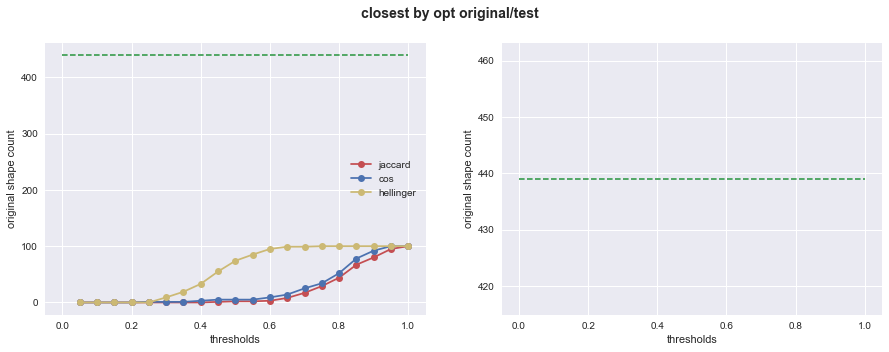

In [36]:
def create_model_dtn_750(n_iteration, model_name='', fit=True, n_topics=750):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 31
functions_list[idx] = create_model_dtn_750
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [21]:
idx = 31
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx],
        init_num_topics=750,
        first_index=names_list[idx])
result_dfs[idx]

0.2          0.4          0.6       0.8
create_model_dtn_750                     -            -            -         -
750 -> 439, 0.97                  24 vs 11  .63 vs 0.39  .78 vs 0.49     --+--
closest by dist test/original       j12-h0      j62-h12      j96-h86  j98-h100
closest by dist original/test       j12-h0      j62-h12      j96-h86  j98-h100
closest by opt res test/original       jh0        j0-h3       j1-h36   j34-h78
closest by opt res original/test       jh0       j0-h33       j3-h95  j44-h100

name = create_model_dtn_1000_iter_0, n_topics = 1000, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 558, [u'topic_1', u'topic_2', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_36', u'topic_37', u'topic_39', u'topic_43', u'topic_44', u'topic_46', u'topic_49', u'topic_50', u'topic_52', u'topic_53', u'topic_55', u'topic_59', u'topic_61', u'topic_62', u'topic_63', u'topic_64', u'topic_66', u'topic_67', u'topic_68', u'topic_69', u'topic_70', u'topic_71', u'topic_73', u'topic_74', u'topic_75', u'topic_79', u'topic_80', u'topic_81', u'topic_83', u'topic_88', u'topic_92', u'topic_94', u'topic_95', u'topic_97', u'topic_99', u'

phi_1    phi_2
num words                      8051.00  8051.00
num topics                      100.00   558.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       7689.02  7789.60
|phi_ij > 0.2| / n_topics         0.03     0.65
|phi_ij > 0.1| / n_topics         0.31     1.63
|phi_ij > 0.01| / n_topics       14.64    18.49
|phi_ij > 0.05| / n_topics        1.21     3.99
|phi_ij > 0.001| / n_topics     214.17    49.55
topic_kernel_average_size        23.68     8.63
topic_kernel_average_purity       0.63     0.34
topic_kernel_average_contrast     0.78     0.43

Dist fn = <function kl_sym_dist at 0x000000000BD26908>, Processed th = 100, original columns count = 558        Processing <function jaccard_dist at 0x000000000BD26978>
Processing <function cos_dist at 0x000000000BD26A58>
Processing <function hellinger_dist at 0x000000000BD26AC8>
Processing <function kl_dist at 0x000000000BD26898>
Processing <function kl_sym_dist at 0x000000000BD26908>
Processing <function jaccard_dist at 0x000000000BD26978>


KeyboardInterrupt: 

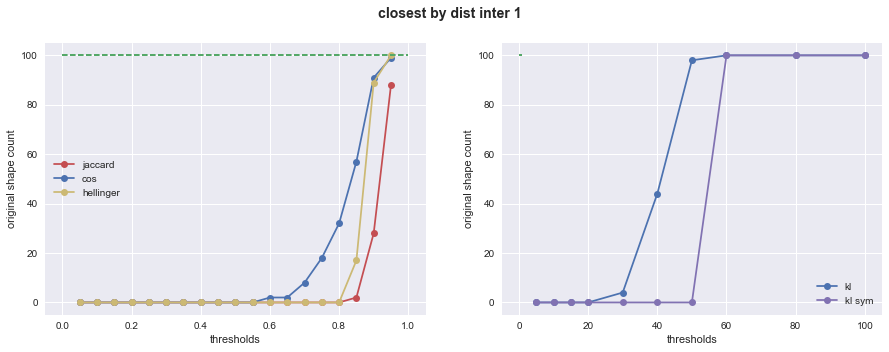

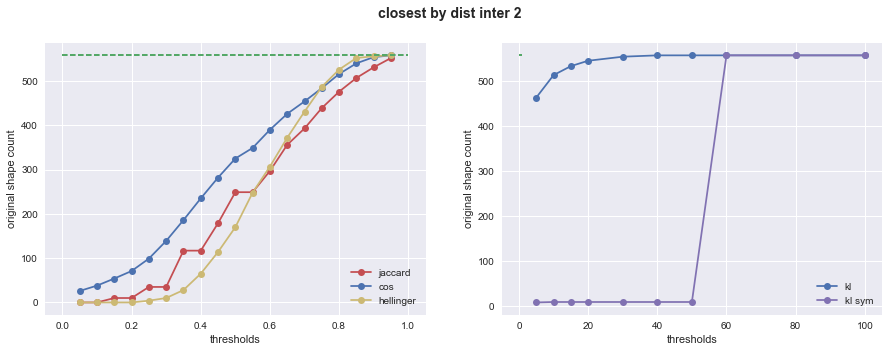

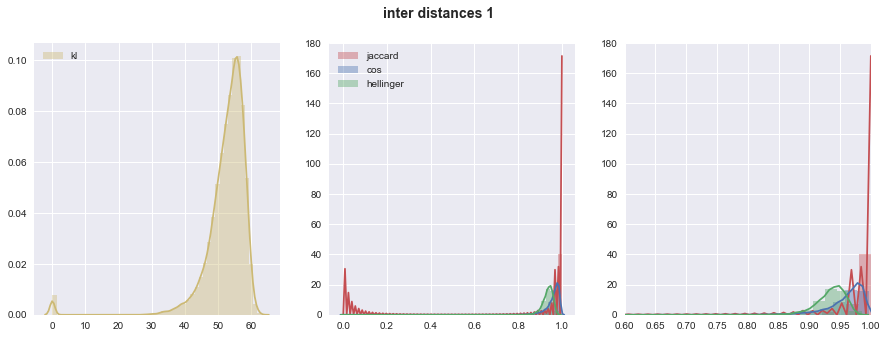

In [37]:
def create_model_dtn_1000(n_iteration, model_name='', fit=True, n_topics=1000):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 32
functions_list[idx] = create_model_dtn_1000
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [22]:
idx = 32
result_dfs[idx] = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx],
        init_num_topics=1000,
        first_index=names_list[idx])
result_dfs[idx]

AttributeError: 'int' object has no attribute 'loc'

In [38]:
save_pickle_file([different_inter_distances_closest_1, different_inter_distances_closest_2, 
        different_inter_distances_1, different_inter_distances_2, 
        different_to_original_distances_closest_1, different_to_test_distances_closest_2, 
        different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix], 'result_no_reg.p')
save_pickle_file([names_list, phi_list, phi_nwt_list, theta_list,
                  phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list], 'init_no_reg.p')

In [23]:
result_dfs_nz = [item for item in result_dfs if type(item) != int]
result_dfs_nz = pd.concat(result_dfs_nz)
result_dfs_nz

0.2          0.4          0.6  \
create_model_dtn_20                       -            -            -   
20 -> 20, 0.91                    24 vs 242  .63 vs 0.68  .78 vs 0.84   
closest by dist test/original           jh0          jh0        j0-h6   
closest by dist original/test           jh0          jh0        j0-h6   
closest by opt res test/original        jh0        j0-h6       j3-h20   
closest by opt res original/test        jh0          jh0        j0-h2   
create_model_dtn_50                       -            -            -   
50 -> 50, 0.95                     24 vs 96  .63 vs 0.62  .78 vs 0.83   
closest by dist test/original           jh0        j9-h6      j34-h44   
closest by dist original/test           jh0        j9-h6      j34-h44   
closest by opt res test/original        jh0       j0-h15       j1-h50   
closest by opt res original/test        jh0        j0-h5       j0-h24   
create_model_dtn_100                      -            -            -   
100 -> 96, 0.96                    24 vs 50  .63 vs 0.59  .78 vs 0.77   
closest by dist test/original        j11-h0      j48-h17      j77-h75   
closest by dist original/test        j11-h0      j48-h17      j77-h75   
closest by opt res test/original        jh0       j0-h20       j0-h79   
closest by opt res original/test        jh0       j0-h18       j0-h78   
create_model_dtn_150                      -            -            -   
150 -> 138, 0.96                   24 vs 34  .63 vs 0.54  .78 vs 0.71   
closest by dist test/original        j12-h0      j61-h19      j91-h85   
closest by dist original/test        j12-h0      j61-h19      j91-h85   
closest by opt res test/original        jh0       j0-h18       j0-h70   
closest by opt res original/test        jh0       j0-h26       j0-h89   
create_model_dtn_200                      -            -            -   
200 -> 168, 0.96                   24 vs 29  .63 vs 0.54  .78 vs 0.70   
closest by dist test/original        j12-h0      j63-h18      j93-h86   
closest by dist original/test        j12-h0      j63-h18      j93-h86   
closest by opt res test/original        jh0       j0-h15       j0-h65   
closest by opt res original/test        jh0       j0-h31       j0-h94   
create_model_dtn_250                      -            -            -   
250 -> 192, 0.96                   24 vs 25  .63 vs 0.52  .78 vs 0.68   
closest by dist test/original        j16-h0      j68-h21      j96-h86   
closest by dist original/test        j16-h0      j68-h21      j96-h86   
closest by opt res test/original        jh0       j0-h10       j1-h53   
closest by opt res original/test        jh0       j0-h39       j0-h96   
create_model_dtn_300                      -            -            -   
300 -> 214, 0.97                   24 vs 22  .63 vs 0.51  .78 vs 0.68   
closest by dist test/original        j18-h0      j68-h17      j96-h89   
closest by dist original/test        j18-h0      j68-h17      j96-h89   
closest by opt res test/original        jh0        j0-h4       j1-h45   
closest by opt res original/test        jh0       j0-h37       j0-h98   
create_model_dtn_350                      -            -            -   
350 -> 242, 0.97                   24 vs 20  .63 vs 0.50  .78 vs 0.65   
closest by dist test/original        j13-h0      j65-h14      j96-h89   
closest by dist original/test        j13-h0      j65-h14      j96-h89   
closest by opt res test/original        jh0        j0-h4       j0-h49   
closest by opt res original/test        jh0       j0-h36       j1-h96   
create_model_dtn_400                      -            -            -   
400 -> 262, 0.97                   24 vs 18  .63 vs 0.50  .78 vs 0.63   
closest by dist test/original         j7-h0      j66-h13      j96-h86   
closest by dist original/test         j7-h0      j66-h13      j96-h86   
closest by opt res test/original        jh0        j0-h2       j0-h46   
closest by opt res original/test        jh0       j0-h39       j1-h94   
create_model_dtn_500     